## Utilization calculation

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import csv
from tabulate import tabulate

def utilization_calc(rho_df, obj):
    rho_df.drop(columns=['stat'], inplace=True)
    rho_df.to_csv('test.csv', index=False)
    interarrival_df = rho_df[rho_df['metric'] == 'interarrival']
    service_df = rho_df[rho_df['metric'] == 'service']

    interarrival_df = interarrival_df.rename(columns={'value': 'interarrival'})
    service_df = service_df.rename(columns={'value': 'service'})

    interarrival_df = interarrival_df.drop(columns=['metric'])
    service_df = service_df.drop(columns=['metric'])
    rho_df = pd.merge(interarrival_df, service_df, on=['lambda', 'node', 'iteration'], how='inner', validate='one_to_one')
    rho_df['utilization'] = rho_df['service'] / rho_df['interarrival']

    rho_df = rho_df[['iteration','lambda','node','interarrival','service','utilization']]
    rho_df.to_csv(os.path.join('output',f'{obj}_rho.csv'), index=False)
    rho_df = rho_df.rename(columns={'utilization': 'value'})
    rho_df['metric'] = 'utilization'
    rho_list = []
    for node in rho_df['node'].unique():
        node_df = rho_df[rho_df['node'] == node]
        rho_list.append(node_df)
    return rho_list

## Preprocessing


All csv files containing run statistics are read and a single dataframe is created with the concatenated csvs by adding a 'lambda' column with the arrival rate values. Three other columns are extracted from the 'statistic' column: 'node' containing the reference node of the statistic or system if it is global, 'metric' indicating the measured metric and finally 'stat' specifying whether the measured value is mean, minimum, maximum or standard deviation.

Finally, a list of dataframes is created one for each metric and node taking only the mean as the statistic.

In [29]:
output_path = os.path.join(".", "output")
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Function to remove outliers based on Z-score
def remove_outliers_zscore(df, column, threshold=3):
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    return df[z_scores <= threshold]

def preprocessing(path, obj):
    filenames = os.listdir(path)
    stats_df_list = []
    for i in filenames:
        lambda_val = i.split('=')[1].split('_')[0]
        stats_path = os.path.join(path, i)
        stats_df = pd.read_csv(stats_path)
        stats_df['lambda'] = lambda_val
        stats_df_list.append(stats_df)
    stats_df = pd.concat(stats_df_list)

    stats_df['node'] = stats_df['statistic'].apply(lambda x: x.split('-')[0])
    stats_df['metric'] = stats_df['statistic'].apply(lambda x: x.split('-')[1])
    stats_df['stat'] = stats_df['statistic'].apply(lambda x: x.split('-')[2])
    stats_df.drop(columns=['statistic'], inplace=True)

    stats_df = stats_df[stats_df['stat'] == 'avg']
    utilization_df = stats_df[stats_df['metric'] == 'interarrival']
    utilization_df = pd.concat([stats_df[stats_df['metric'] == 'service'], utilization_df])
    
    # List of one DataFrame for each metric selecting only the average as statistic
    metrics = stats_df['metric'].unique()
    metrics_avg_df_list = []
    metrics = metrics[metrics != 'interarrival']
    metrics = metrics[metrics != 'service']
    
    for i in metrics:
        metrics_avg_df = stats_df[stats_df['metric'] == i]
        
        # Remove outliers for the 'value' column (or other numerical columns)
        if 'value' in metrics_avg_df.columns:
            metrics_avg_df = remove_outliers_zscore(metrics_avg_df, 'value')
        
        metrics_avg_df_list.append(metrics_avg_df)

    metrics_nodes_avg_df_list = []
    for i in metrics_avg_df_list:
        nodes = i['node'].unique()
        node_avg_df_list = []
        for j in nodes:
            node_avg_df = i[i['node'] == j]
            node_avg_df_list.append(node_avg_df)
        metrics_nodes_avg_df_list.append(node_avg_df_list)
    metrics_nodes_avg_df_list.append(utilization_calc(utilization_df, obj))
    return metrics_nodes_avg_df_list


## Boxplot funcion
Boxplots of the average of population number, throughput and response time with arrival rate in a range 0.5, 1.2 job/sec

In [30]:
def boxplot(metrics_nodes_avg_df_list):    
    for metric in metrics_nodes_avg_df_list:
        figure, axis = plt.subplots(2, 2, figsize=(15, 10))
        for i, boxplot_df in enumerate(metric):
            boxplot_df['value'].astype(float)
            boxplot_df['lambda'].astype(float)
            boxplot_df = boxplot_df.sort_values(by='lambda')

            curr_metric = boxplot_df['metric'].unique()[0]
            curr_node = boxplot_df['node'].unique()[0]
            x = i // 2
            y = i % 2

            boxplot_df.boxplot(column='value', by='lambda', ax = axis[x, y], showfliers=False)
            plt.suptitle('')
            axis[x, y].set_title(f'Boxplot of {curr_metric} of the {curr_node} node')

        plt.tight_layout()
        plt.show()

## Confidence interval calculation
Confidence intervals are calculated on the batches of runs made as the lambda parameter changes.

The following formula is used to calculate the interval:

$
CI = \bar{x} \pm z \cdot \frac{\sigma}{\sqrt{n}}
$

Where:
- $\bar{x}$ is the sample mean.
- $z$ is the critical value of the standard normal distribution corresponding to the chosen confidence level (e.g., 1.96 for 95%).
- $\sigma$ is the population standard deviation.
- $n$ is the sample size.

In [31]:
def confidence_interval(metrics_nodes_avg_df_list, critical_value, obj):
    ci_df = []
    for metric in metrics_nodes_avg_df_list:
        metric_list = []
        for node_df in metric:
            curr_metric = node_df['metric'].unique()[0]
            curr_node = node_df['node'].unique()[0]
            
            df = node_df.groupby(["lambda"])['value'].describe()[["count", "mean", "std"]].reset_index()
            df["lower_ci"] = df["mean"] - critical_value*(df["std"]/np.sqrt(df["count"]))
            df["upper_ci"] = df["mean"] + critical_value*(df["std"]/np.sqrt(df["count"]))

            df.to_csv(os.path.join("output", f"{obj}_conf_int_{curr_node}_{curr_metric}.csv"), index=False)
            df['metric'] = curr_metric
            df['node'] = curr_node
            metric_list.append(df)
        ci_df.append(metric_list)
    return ci_df

In [32]:
def plot_confidence_interval(ci_df, analytical_perf):
    colors = {'A': ['crimson', 'darkred'], 'B': ['darkblue', 'royalblue'], 'P': ['darkgreen', 'limegreen']}
    for metric in ci_df:
        fig, axis = plt.subplots(2, 2, figsize=(15, 10))
        for i, df in enumerate(metric):
            x = i // 2
            y = i % 2

            curr_metric = df['metric'].unique()[0]
            curr_node = df['node'].unique()[0]

            analitycal_df = analytical_perf[curr_metric][curr_node]
            
            # error bar plot with mean point
            up = df['upper_ci'] - df['mean']
            low = df['mean'] - df['lower_ci']
            axis[x, y].errorbar(df['lambda'], df['mean'], yerr=[low, up], fmt='o', capsize=5, label='Confidence interval 95%')

            # lineplot of the mean points
            axis[x, y].plot(df['lambda'], df['mean'], linestyle='-', marker='o', color='b', label='Avg')
            axis[x, y].plot(df['lambda'], analitycal_df['value'], linestyle='-', marker='o', color='r', label='Avg')

            axis[x, y].set_xlabel('Lambda')
            axis[x, y].set_ylabel(f"Avg {curr_metric} in {curr_node}")
            axis[x, y].set_title(f"Confidence interval for {curr_node} average {curr_metric}")
            axis[x, y].legend()
        plt.tight_layout()
        plt.show()

        if 'throughput' in df['metric'].values:
            fig, ax = plt.subplots(figsize=(10, 6))

            for df in metric:
                if df['node'].unique()[0] == 'SYSTEM':
                    continue
                base_color = colors[df['node'].unique()[0]][0]
                darker_color = colors[df['node'].unique()[0]][1]
                ax.errorbar(df['lambda'], df['mean'], 
                            yerr=[df['mean'] - df['lower_ci'], df['upper_ci'] - df['mean']], 
                            fmt='o', capsize=5, color = darker_color)

                ax.plot(df['lambda'], df['mean'], linestyle='-', marker='o', label=f'Throughput of {df["node"].unique()[0]}', color = base_color)

            # Aggiunta delle etichette e del titolo
            ax.set_xlabel('Lambda')
            ax.set_ylabel('Avg')
            ax.set_title('Throughput comparison')
            ax.legend()
            # Mostra il grafico
            plt.show()


## Simulation vs. Analitycal model

In [33]:
def analitycal_preprocessing(obj):
    metric_node_analitycal_dict = {}
    servers = ['[A]', '[B]', '[P]', '[S]']
    metrics = {'E[T]': 'response_time', 'E[N]': 'population', 'X': 'throughput', 'rho': 'utilization'} 

    local_perf = pd.read_csv(os.path.join('output', f'{obj}_analitycal_local_performances.csv'))
    global_perf = pd.read_csv(os.path.join('output', f'{obj}_analitycal_global_performances.csv'))
    rho_perf = pd.read_csv(os.path.join('output', f'{obj}_analitycal_rho.csv'))
    analitycal_perf = pd.merge(local_perf, global_perf, on=['gamma'], how='inner', validate='one_to_one')
    analitycal_perf = pd.merge(analitycal_perf, rho_perf, on=['gamma'], how='inner', validate='one_to_one')
    
    for m in metrics.keys():
        metric_columns = [col for col in analitycal_perf.columns if col.startswith(m)]
        metric_df = analitycal_perf[metric_columns].copy()
        metric_df['metric'] = metrics[m]
        node_dict = {}
        for s in servers:
            s_column = [col for col in metric_df.columns if col.endswith(s)]
            if not s_column:
                continue
            s_df = metric_df[s_column].copy()

            s_df = s_df.rename(columns={s_column[0]: 'value'})
            node = s.split('[')[1].split(']')[0]
            node = 'SYSTEM' if node == 'S' else node
            s_df['node'] = node
            s_df['lambda'] = analitycal_perf['gamma'].copy().astype(float)
            s_df['metric'] = metric_df['metric'].unique()[0]
            node_dict[node] = s_df
        metric_node_analitycal_dict[metrics[m]] = node_dict

    return metric_node_analitycal_dict


def average_stats(stats_df, analytical_perf):
    avg_metric_list = []
    for metric in stats_df:
        average_list_node = []
        for node in metric:
            node.drop(columns=['iteration'], inplace=True)
            node = node.groupby(['lambda', 'metric', 'node'])['value'].mean().reset_index()
            node['lambda'] = node['lambda'].astype(float)
            merging_df = analytical_perf[node['metric'].unique()[0]][node['node'].unique()[0]]
            
            node = pd.merge(node, merging_df, on=['lambda', 'metric', 'node'], how='inner', validate='one_to_one')
            node['diff'] = abs(node['value_x'] - node['value_y'])
            node.rename(columns={'value_x': 'simulation_value', 'value_y': 'analitycal_value'}, inplace=True)
            average_list_node.append(node)
        avg_metric_list.append(average_list_node)
    return avg_metric_list

## Objective 1

Implementation of a model to execute the web app workflow to measure response time (R), population number (N) and throughput (X) quantities

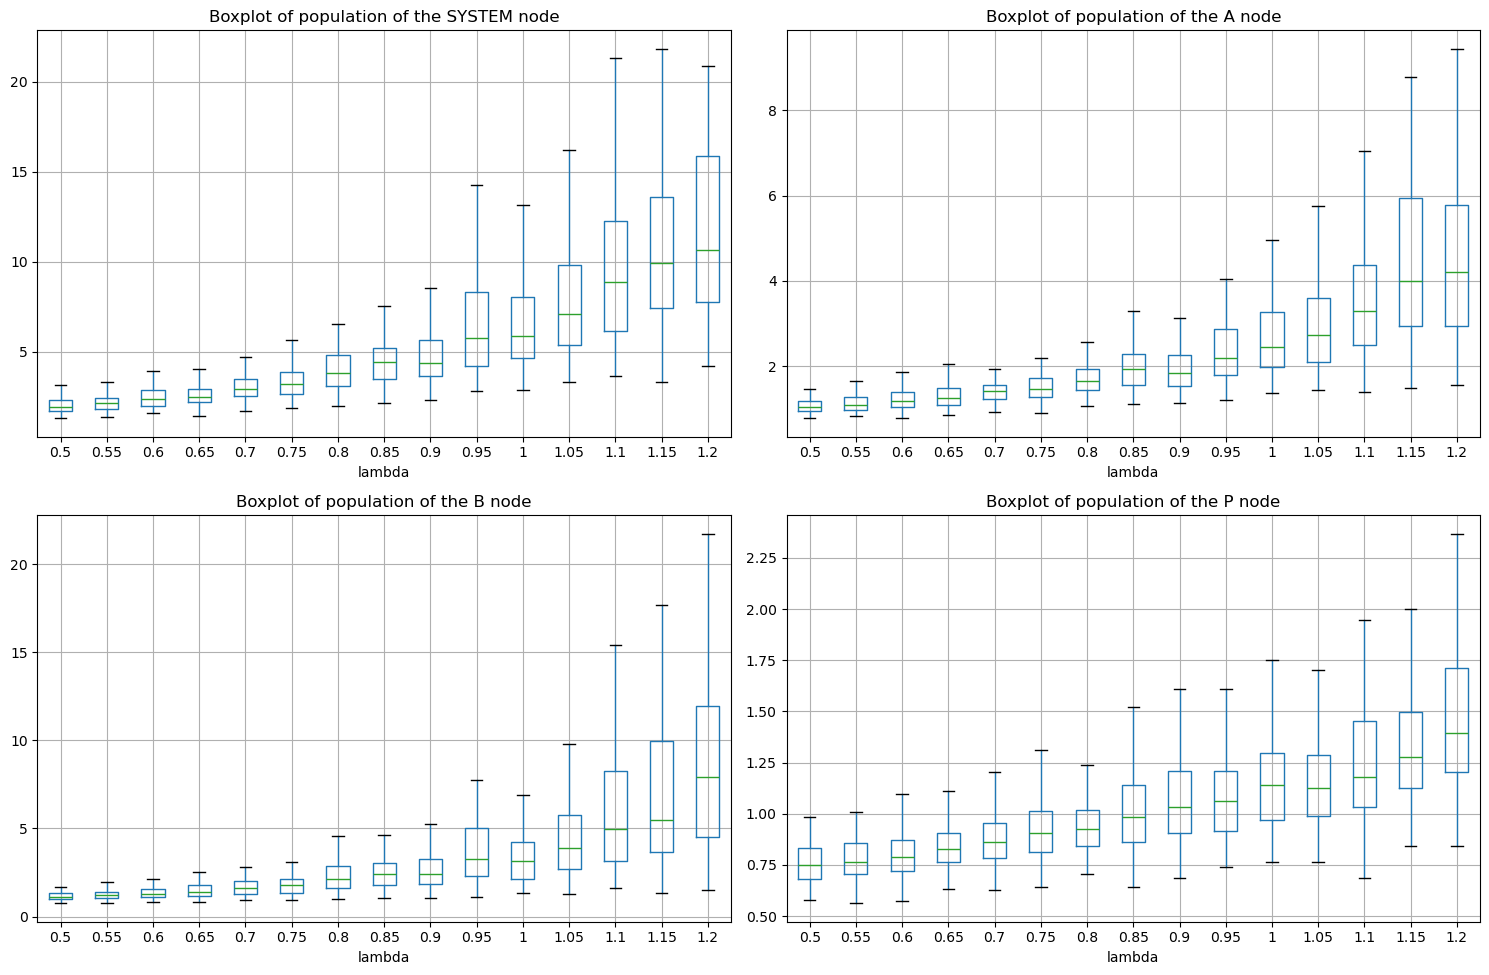

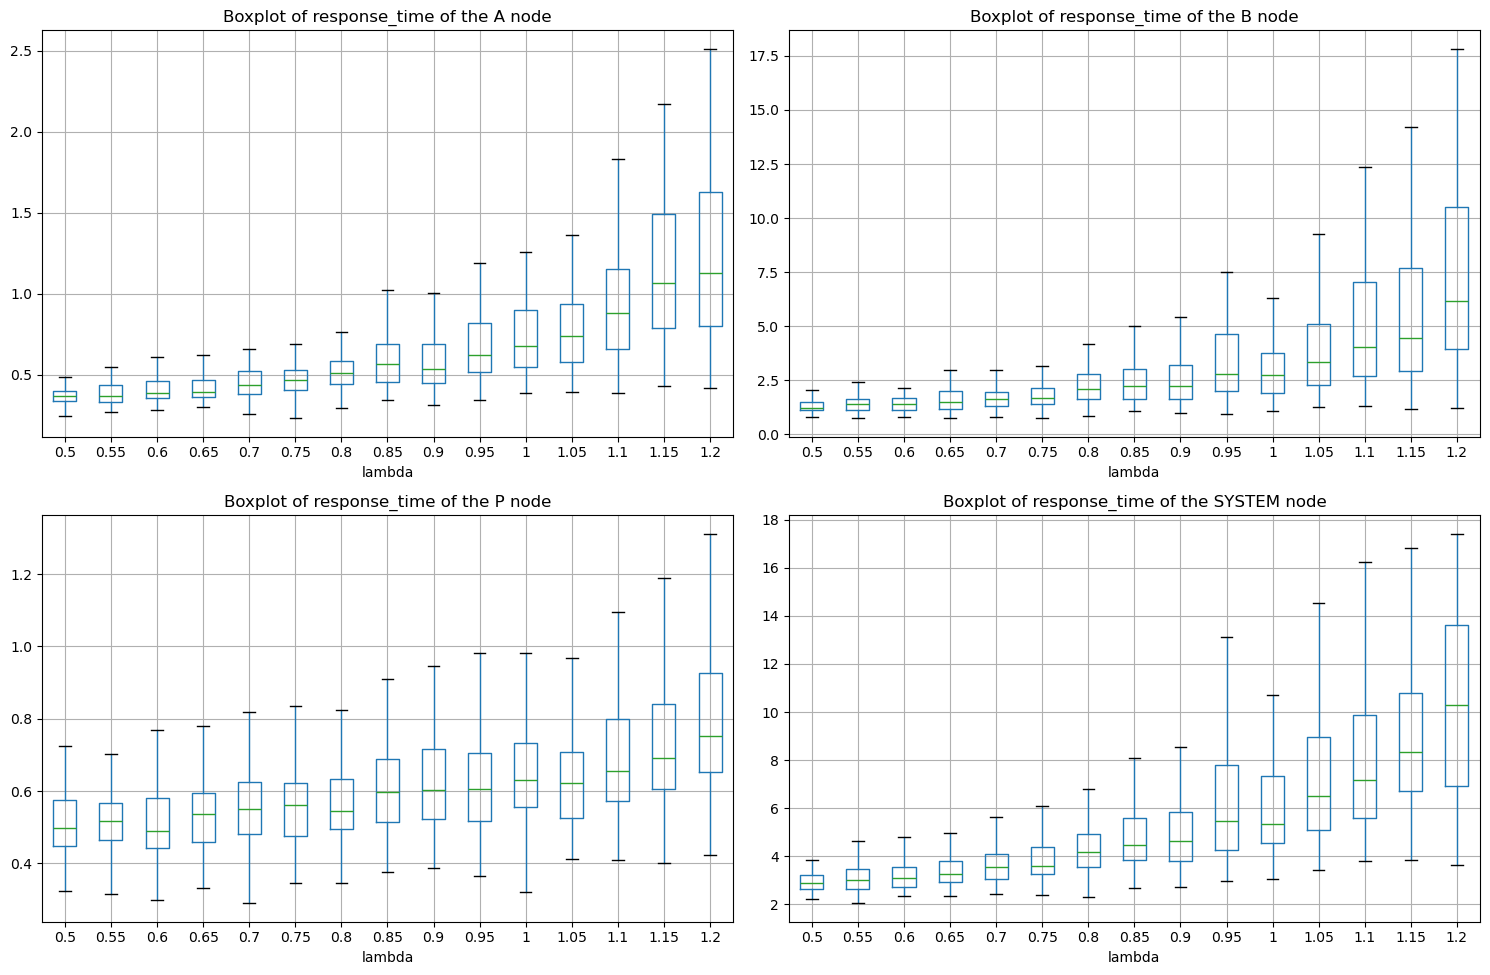

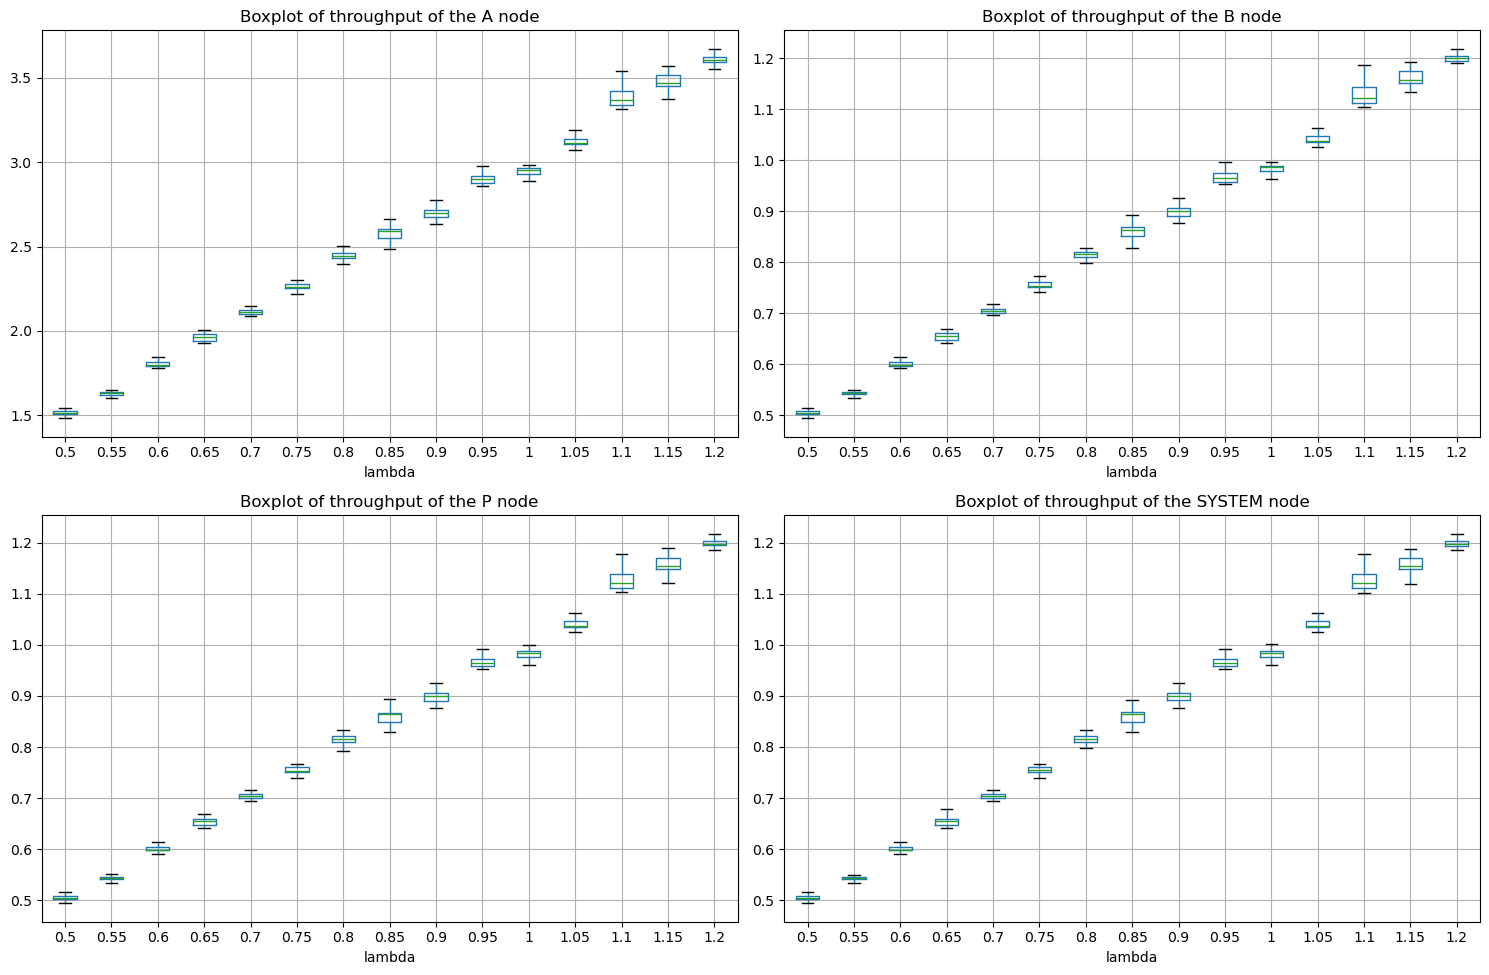

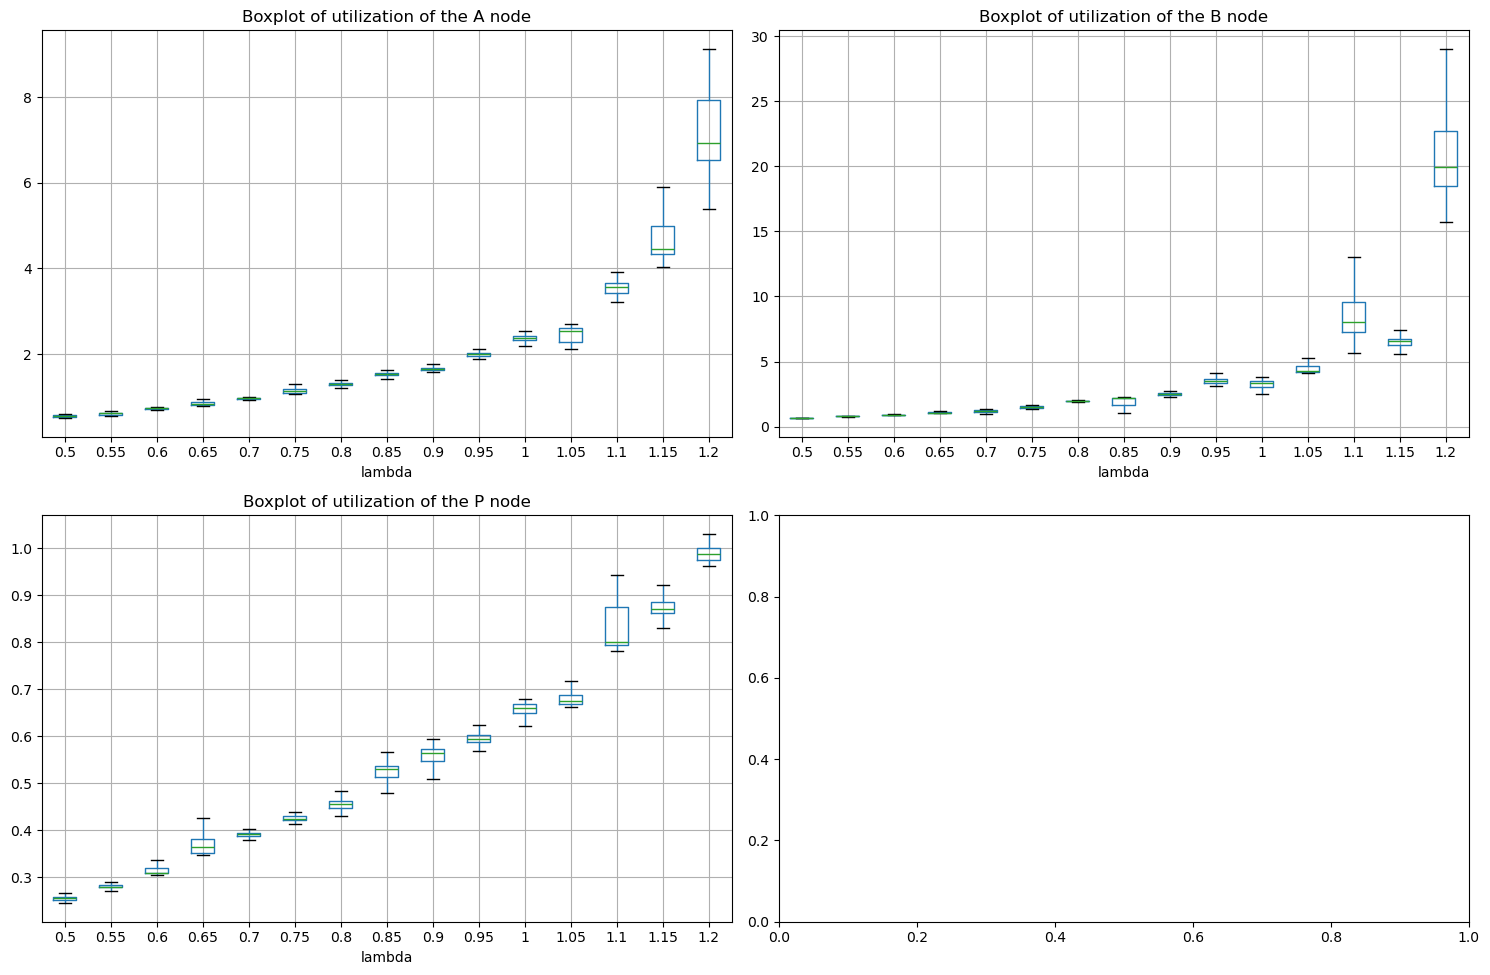

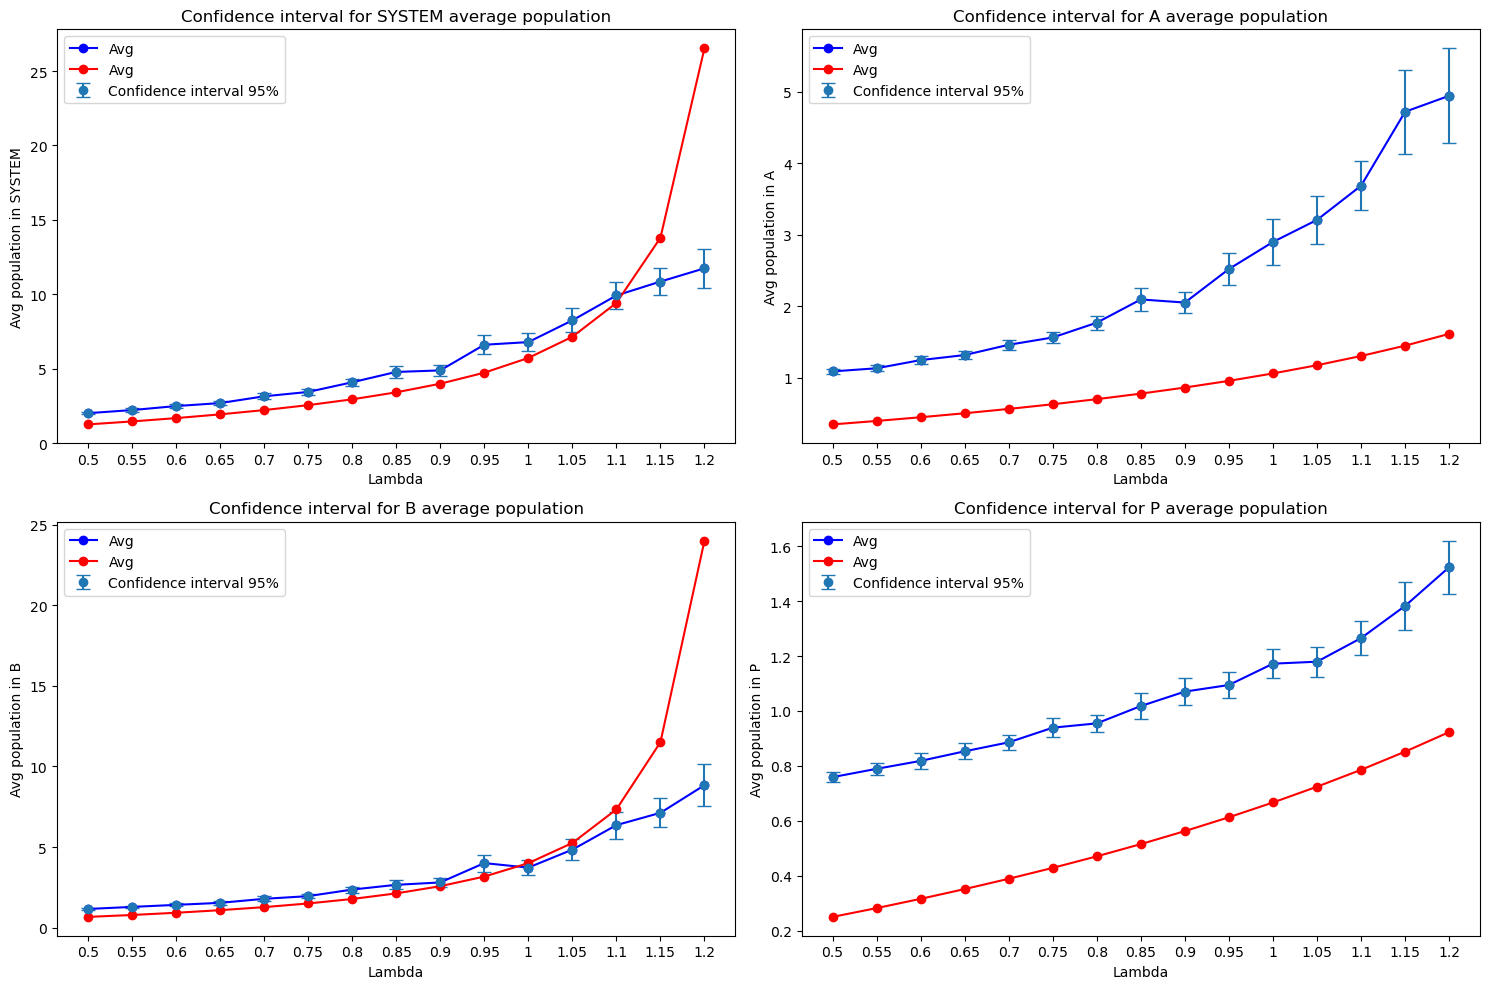

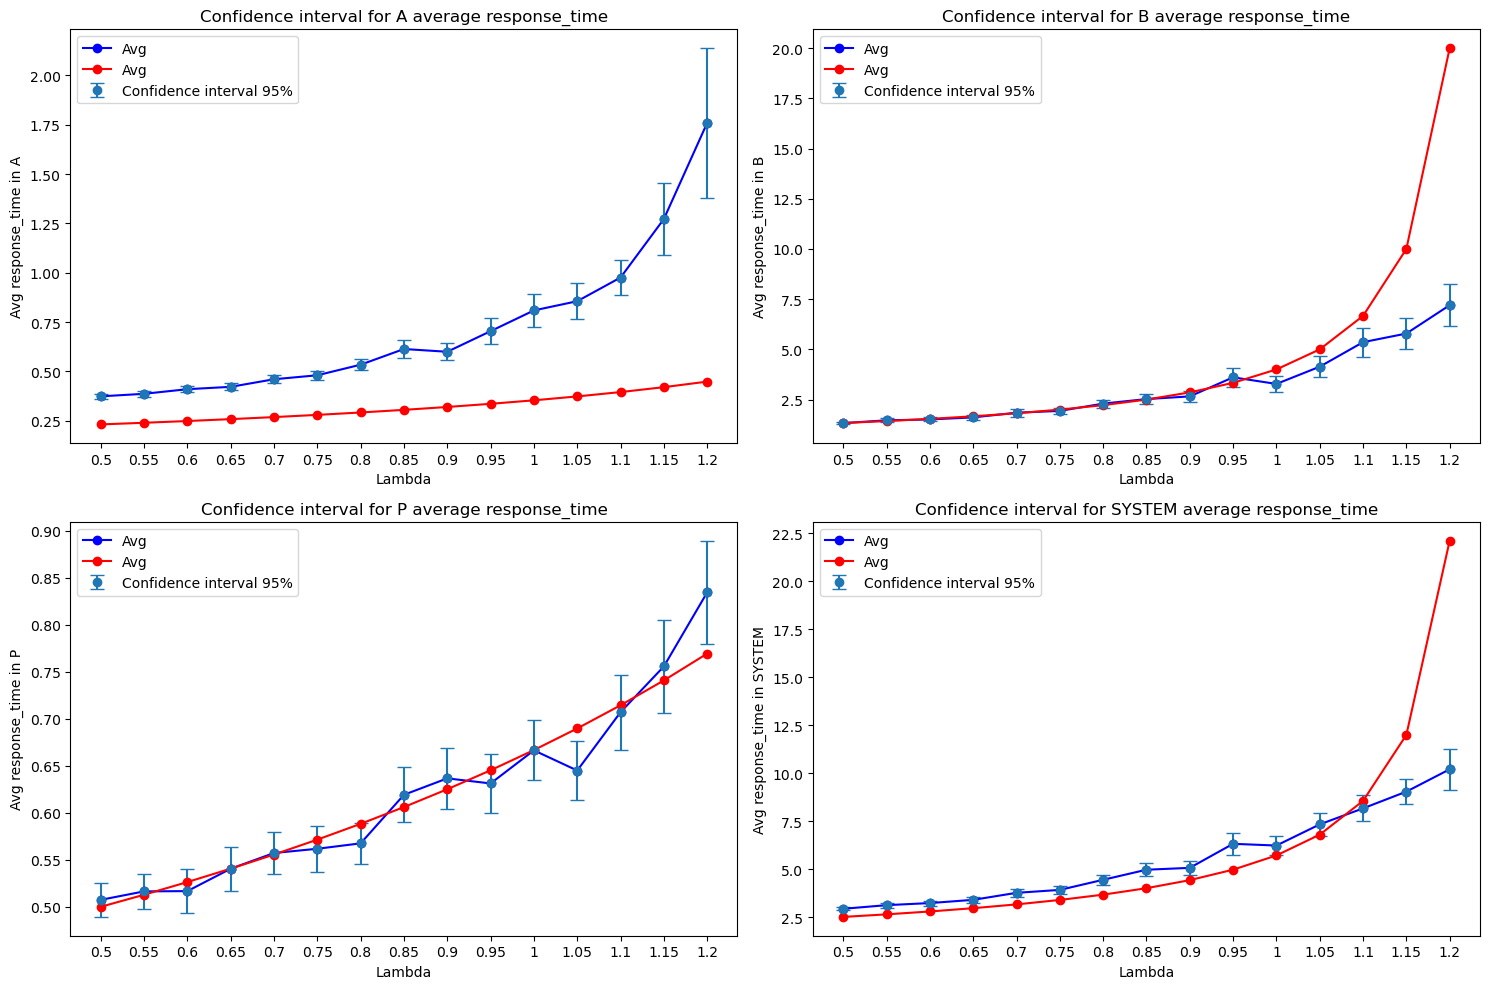

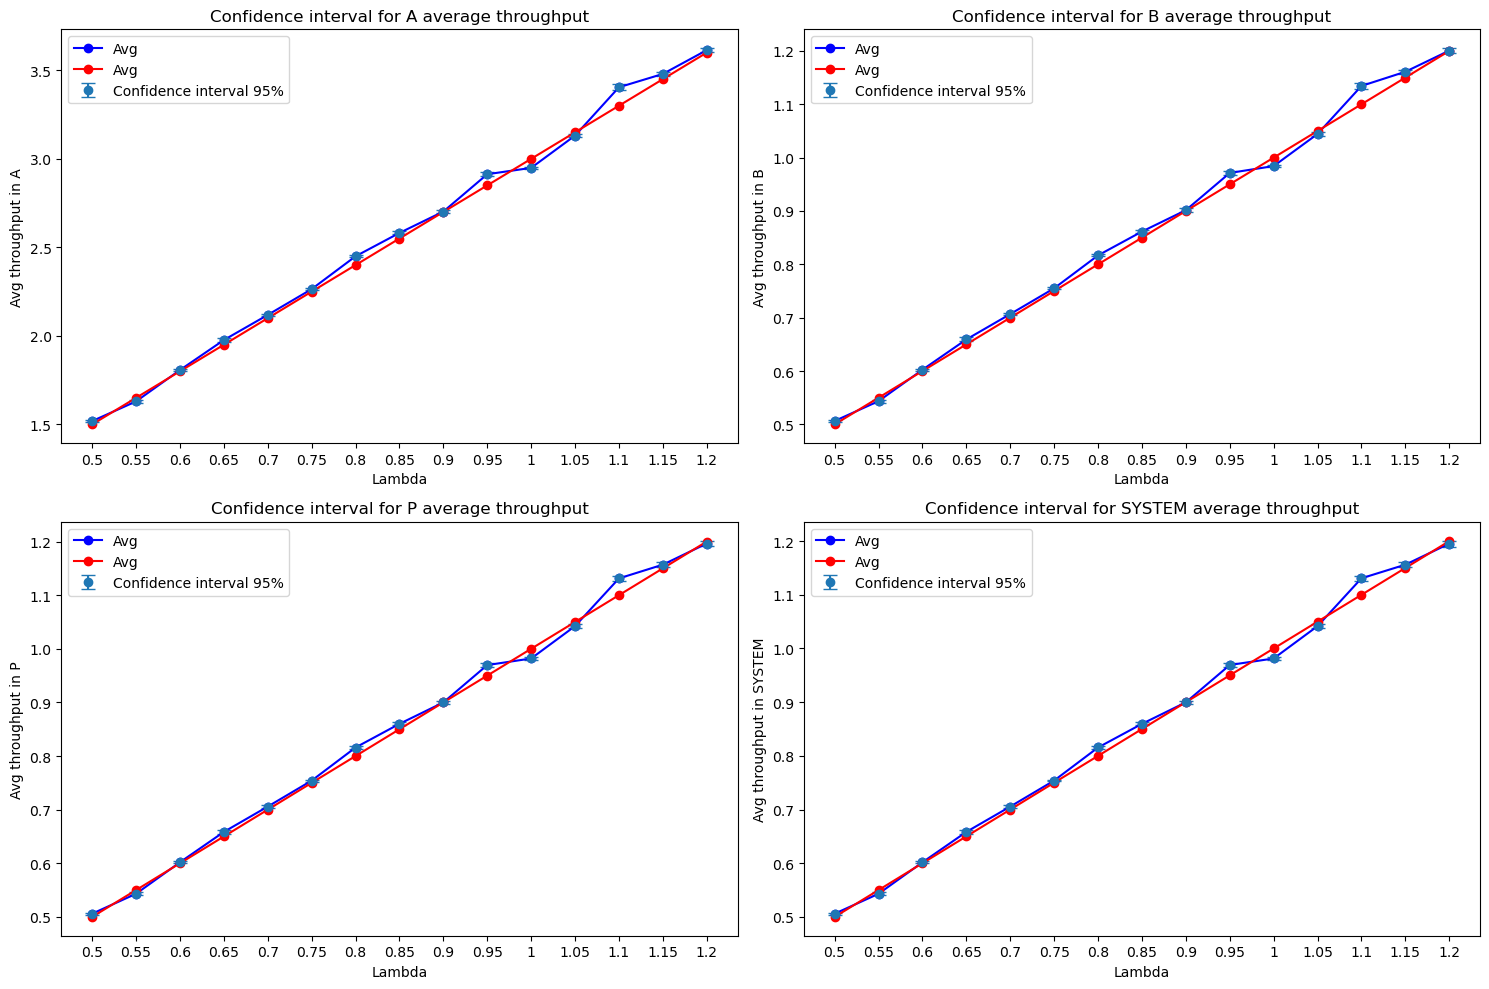

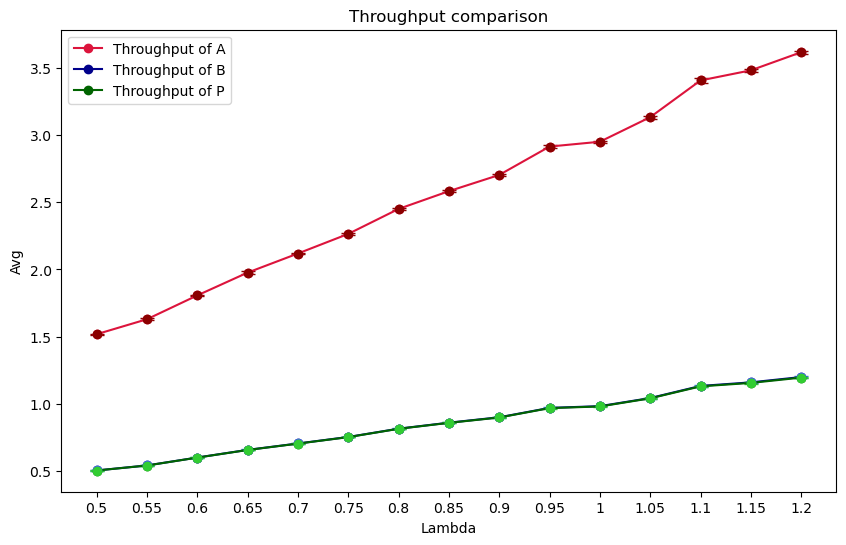

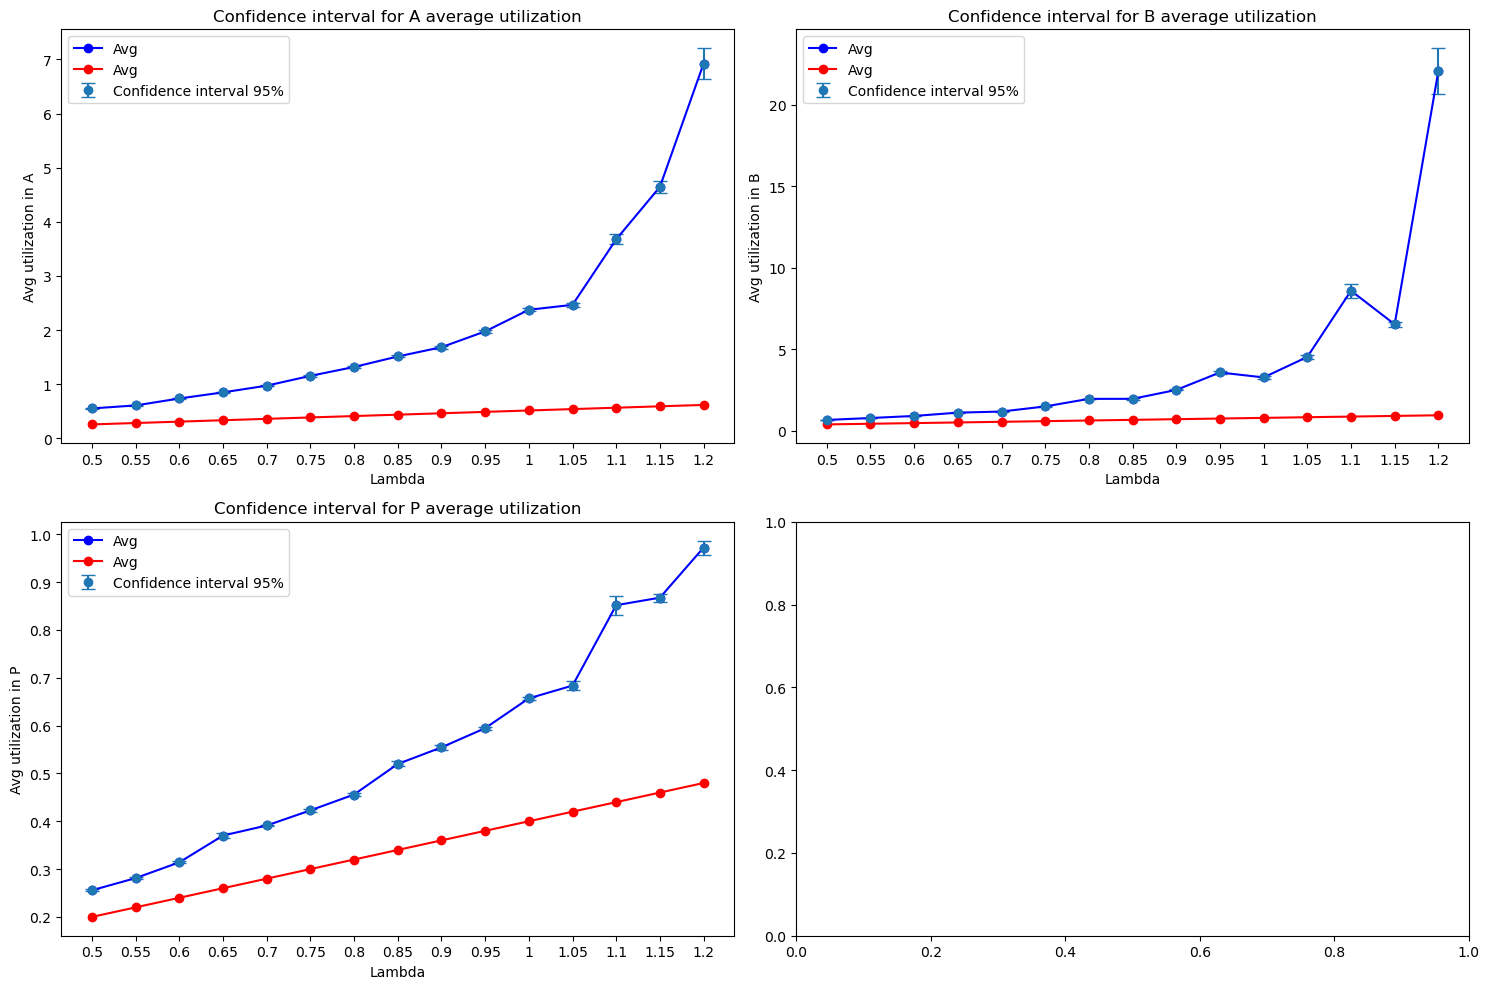

lambda,metric,node,simulation_value,analitycal_value,diff
0.5,population,SYSTEM,2.01698,1.26282,0.754155
0.55,population,SYSTEM,2.22456,1.46219,0.762373
0.6,population,SYSTEM,2.49438,1.68515,0.80923
0.65,population,SYSTEM,2.69527,1.93683,0.758442
0.7,population,SYSTEM,3.14945,2.22412,0.925333
0.75,population,SYSTEM,3.44277,2.55648,0.886289
0.8,population,SYSTEM,4.09165,2.9474,1.14426
0.85,population,SYSTEM,4.78669,3.4168,1.36989
0.9,population,SYSTEM,4.88957,3.99563,0.893944
0.95,population,SYSTEM,6.61334,4.73488,1.87846


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,population,A,1.08719,0.346154,0.741032
0.55,population,A,1.131,0.394422,0.736573
0.6,population,A,1.24536,0.446281,0.799081
0.65,population,A,1.31594,0.502146,0.813791
0.7,population,A,1.45949,0.5625,0.896991
0.75,population,A,1.56172,0.627907,0.933811
0.8,population,A,1.76863,0.699029,1.0696
0.85,population,A,2.09339,0.77665,1.31674
0.9,population,A,2.05,0.861702,1.1883
0.95,population,A,2.51899,0.955307,1.56369


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,population,B,1.15858,0.666667,0.491911
0.55,population,B,1.2865,0.785714,0.500786
0.6,population,B,1.41289,0.923077,0.489814
0.65,population,B,1.53856,1.08333,0.455228
0.7,population,B,1.78709,1.27273,0.514365
0.75,population,B,1.9549,1.5,0.454903
0.8,population,B,2.36136,1.77778,0.583585
0.85,population,B,2.6569,2.125,0.531902
0.9,population,B,2.8034,2.57143,0.231976
0.95,population,B,4.00384,3.16667,0.837173


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,population,P,0.758962,0.25,0.508962
0.55,population,P,0.789266,0.282051,0.507214
0.6,population,P,0.818183,0.315789,0.502394
0.65,population,P,0.853055,0.351351,0.501704
0.7,population,P,0.885756,0.388889,0.496867
0.75,population,P,0.939114,0.428571,0.510542
0.8,population,P,0.954807,0.470588,0.484219
0.85,population,P,1.01795,0.515152,0.502798
0.9,population,P,1.07049,0.5625,0.507993
0.95,population,P,1.09453,0.612903,0.481631


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,response_time,A,0.373068,0.230769,0.142299
0.55,response_time,A,0.385905,0.239044,0.146861
0.6,response_time,A,0.409331,0.247934,0.161397
0.65,response_time,A,0.421264,0.257511,0.163753
0.7,response_time,A,0.459703,0.267857,0.191846
0.75,response_time,A,0.479922,0.27907,0.200853
0.8,response_time,A,0.533535,0.291262,0.242273
0.85,response_time,A,0.613031,0.304569,0.308462
0.9,response_time,A,0.599073,0.319149,0.279924
0.95,response_time,A,0.703517,0.335196,0.368321


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,response_time,B,1.32774,1.33333,0.00559564
0.55,response_time,B,1.46677,1.42857,0.0381961
0.6,response_time,B,1.51019,1.53846,0.0282735
0.65,response_time,B,1.61275,1.66667,0.0539159
0.7,response_time,B,1.84552,1.81818,0.0273381
0.75,response_time,B,1.93596,2,0.0640371
0.8,response_time,B,2.29901,2.22222,0.0767848
0.85,response_time,B,2.52487,2.5,0.0248709
0.9,response_time,B,2.65781,2.85714,0.199337
0.95,response_time,B,3.60769,3.33333,0.274357


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,response_time,P,0.50739,0.5,0.00739004
0.55,response_time,P,0.51639,0.512821,0.00356952
0.6,response_time,P,0.516684,0.526316,0.00963212
0.65,response_time,P,0.540507,0.540541,3.35734e-05
0.7,response_time,P,0.557197,0.555556,0.0016416
0.75,response_time,P,0.561719,0.571429,0.00970941
0.8,response_time,P,0.567469,0.588235,0.0207668
0.85,response_time,P,0.619114,0.606061,0.0130534
0.9,response_time,P,0.636573,0.625,0.0115734
0.95,response_time,P,0.631175,0.645161,0.0139859


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,response_time,SYSTEM,2.94852,2.52564,0.422878
0.55,response_time,SYSTEM,3.13697,2.65852,0.478447
0.6,response_time,SYSTEM,3.24628,2.80858,0.437705
0.65,response_time,SYSTEM,3.41361,2.97974,0.433869
0.7,response_time,SYSTEM,3.77936,3.17731,0.602051
0.75,response_time,SYSTEM,3.93113,3.40864,0.522496
0.8,response_time,SYSTEM,4.45734,3.68424,0.773097
0.85,response_time,SYSTEM,4.9817,4.01977,0.961929
0.9,response_time,SYSTEM,5.07935,4.43959,0.639759
0.95,response_time,SYSTEM,6.33089,4.98408,1.34681


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,throughput,A,1.51871,1.5,0.0187092
0.55,throughput,A,1.62996,1.65,0.0200424
0.6,throughput,A,1.80699,1.8,0.00698629
0.65,throughput,A,1.97649,1.95,0.0264948
0.7,throughput,A,2.11843,2.1,0.0184347
0.75,throughput,A,2.26409,2.25,0.0140936
0.8,throughput,A,2.44957,2.4,0.0495658
0.85,throughput,A,2.58155,2.55,0.0315485
0.9,throughput,A,2.70214,2.7,0.00214059
0.95,throughput,A,2.91305,2.85,0.0630548


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,throughput,B,0.506406,0.5,0.00640577
0.55,throughput,B,0.543599,0.55,0.00640145
0.6,throughput,B,0.602411,0.6,0.002411
0.65,throughput,B,0.659238,0.65,0.00923823
0.7,throughput,B,0.706753,0.7,0.00675267
0.75,throughput,B,0.755088,0.75,0.00508753
0.8,throughput,B,0.816778,0.8,0.0167781
0.85,throughput,B,0.861435,0.85,0.0114355
0.9,throughput,B,0.901466,0.9,0.0014656
0.95,throughput,B,0.971293,0.95,0.0212932


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,throughput,P,0.505982,0.5,0.0059822
0.55,throughput,P,0.543133,0.55,0.0068674
0.6,throughput,P,0.601849,0.6,0.00184855
0.65,throughput,P,0.658481,0.65,0.00848144
0.7,throughput,P,0.705725,0.7,0.0057248
0.75,throughput,P,0.75411,0.75,0.00410987
0.8,throughput,P,0.815893,0.8,0.0158931
0.85,throughput,P,0.860011,0.85,0.0100112
0.9,throughput,P,0.899932,0.9,6.76148e-05
0.95,throughput,P,0.969635,0.95,0.0196355


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,throughput,SYSTEM,0.50593,0.5,0.00593031
0.55,throughput,SYSTEM,0.543087,0.55,0.00691311
0.6,throughput,SYSTEM,0.601703,0.6,0.00170304
0.65,throughput,SYSTEM,0.658336,0.65,0.00833579
0.7,throughput,SYSTEM,0.705512,0.7,0.00551192
0.75,throughput,SYSTEM,0.753983,0.75,0.00398322
0.8,throughput,SYSTEM,0.815585,0.8,0.015585
0.85,throughput,SYSTEM,0.859613,0.85,0.00961285
0.9,throughput,SYSTEM,0.899685,0.9,0.000315262
0.95,throughput,SYSTEM,0.969282,0.95,0.0192823


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,utilization,A,0.552364,0.257143,0.295221
0.55,utilization,A,0.607797,0.282857,0.32494
0.6,utilization,A,0.736242,0.308571,0.427671
0.65,utilization,A,0.848929,0.334286,0.514643
0.7,utilization,A,0.973011,0.36,0.613011
0.75,utilization,A,1.15404,0.385714,0.768324
0.8,utilization,A,1.31832,0.411429,0.906895
0.85,utilization,A,1.51233,0.437143,1.07519
0.9,utilization,A,1.68316,0.462857,1.2203
0.95,utilization,A,1.97519,0.488571,1.48662


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,utilization,B,0.673642,0.4,0.273642
0.55,utilization,B,0.791914,0.44,0.351914
0.6,utilization,B,0.918009,0.48,0.438009
0.65,utilization,B,1.12077,0.52,0.600771
0.7,utilization,B,1.18826,0.56,0.628262
0.75,utilization,B,1.50139,0.6,0.901395
0.8,utilization,B,1.96578,0.64,1.32578
0.85,utilization,B,1.96716,0.68,1.28716
0.9,utilization,B,2.51275,0.72,1.79275
0.95,utilization,B,3.58155,0.76,2.82155


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,utilization,P,0.255708,0.2,0.055708
0.55,utilization,P,0.281193,0.22,0.0611931
0.6,utilization,P,0.314163,0.24,0.0741625
0.65,utilization,P,0.370154,0.26,0.110154
0.7,utilization,P,0.391154,0.28,0.111154
0.75,utilization,P,0.422789,0.3,0.122789
0.8,utilization,P,0.455939,0.32,0.135939
0.85,utilization,P,0.519808,0.34,0.179808
0.9,utilization,P,0.554494,0.36,0.194494
0.95,utilization,P,0.594601,0.38,0.214601


In [34]:
path = os.path.join("..", "..", "src", "caballo", "domestico", "wwsimulator", "statistics", "objective_1")
critical_value = scipy.stats.norm.ppf(1-.05/2)
obj = 'obj1'

metrics_nodes_avg_df_list = preprocessing(path, obj)
analytical_perf = analitycal_preprocessing(obj)

boxplot(metrics_nodes_avg_df_list)

ci_df = confidence_interval(metrics_nodes_avg_df_list, critical_value, obj)
plot_confidence_interval(ci_df, analytical_perf)

avg_metrics_list = average_stats(metrics_nodes_avg_df_list, analytical_perf)
for metric in avg_metrics_list:
    for node in metric:
        df = node.reset_index()
        df.drop(columns=['index'], inplace=True)
        display(tabulate(df, headers='keys', tablefmt='html', showindex=False))

## Objective 2

The model adds the functionality of two-factor authentication, observe the three metrics variation.

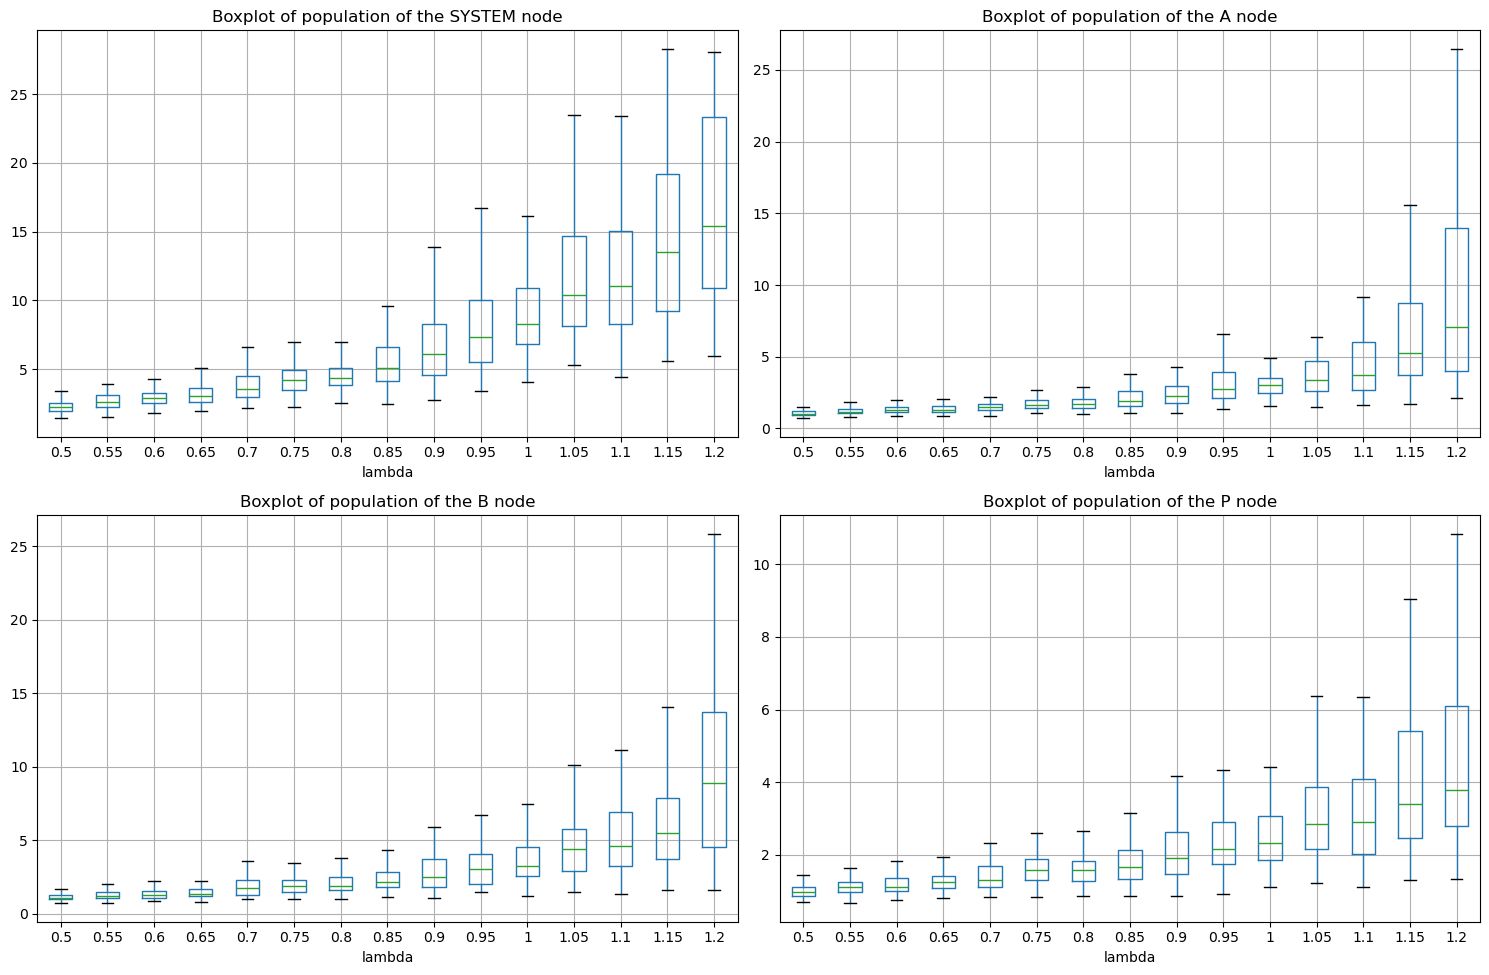

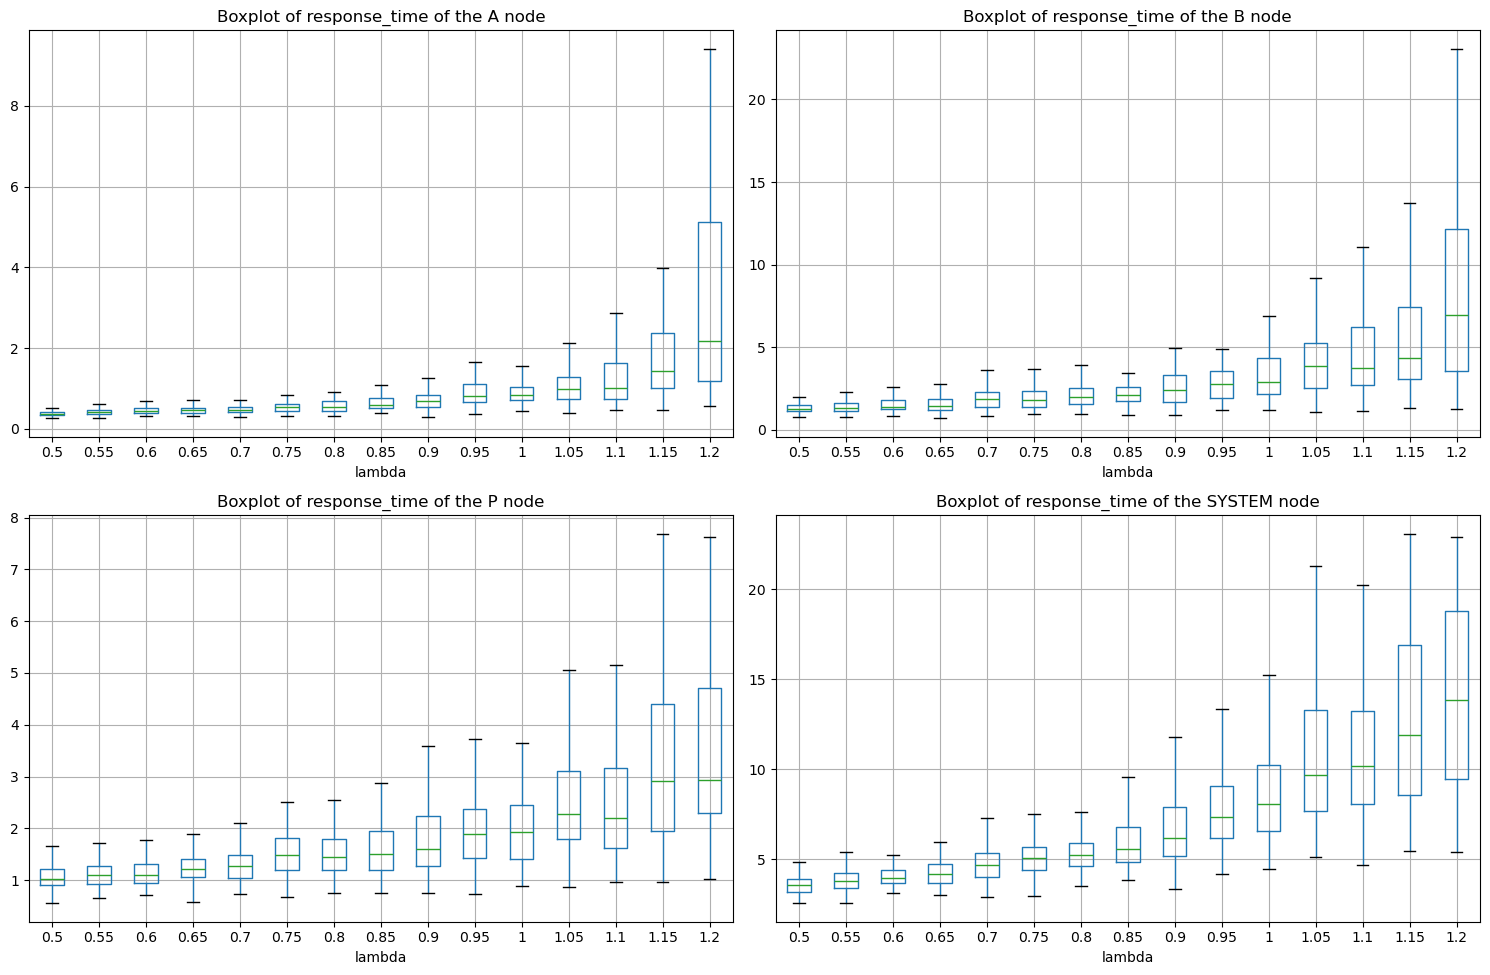

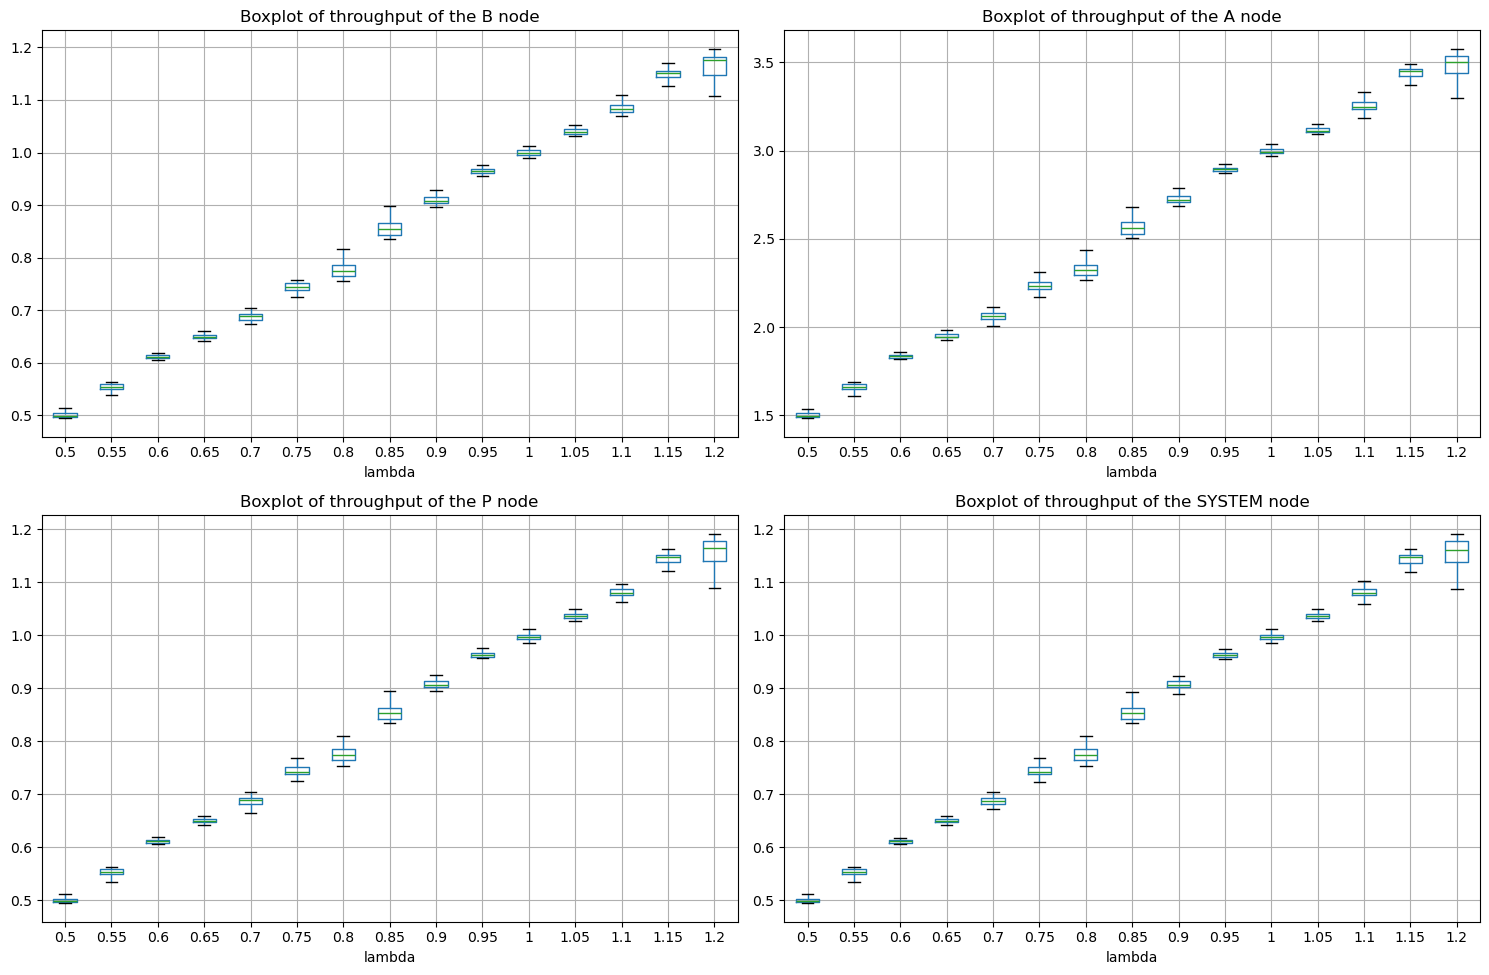

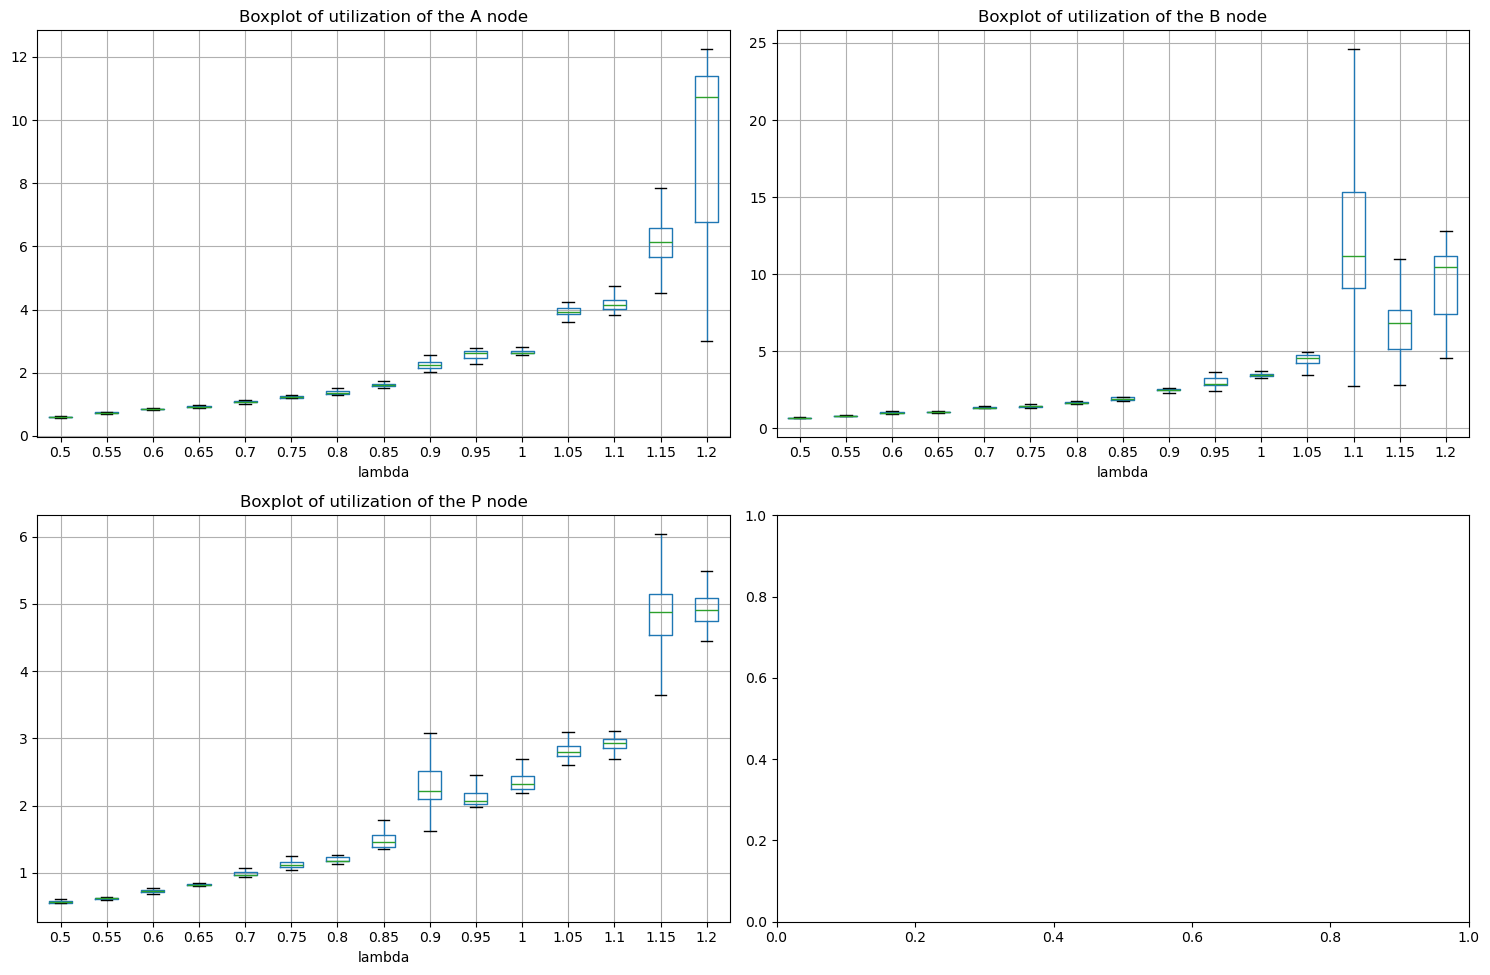

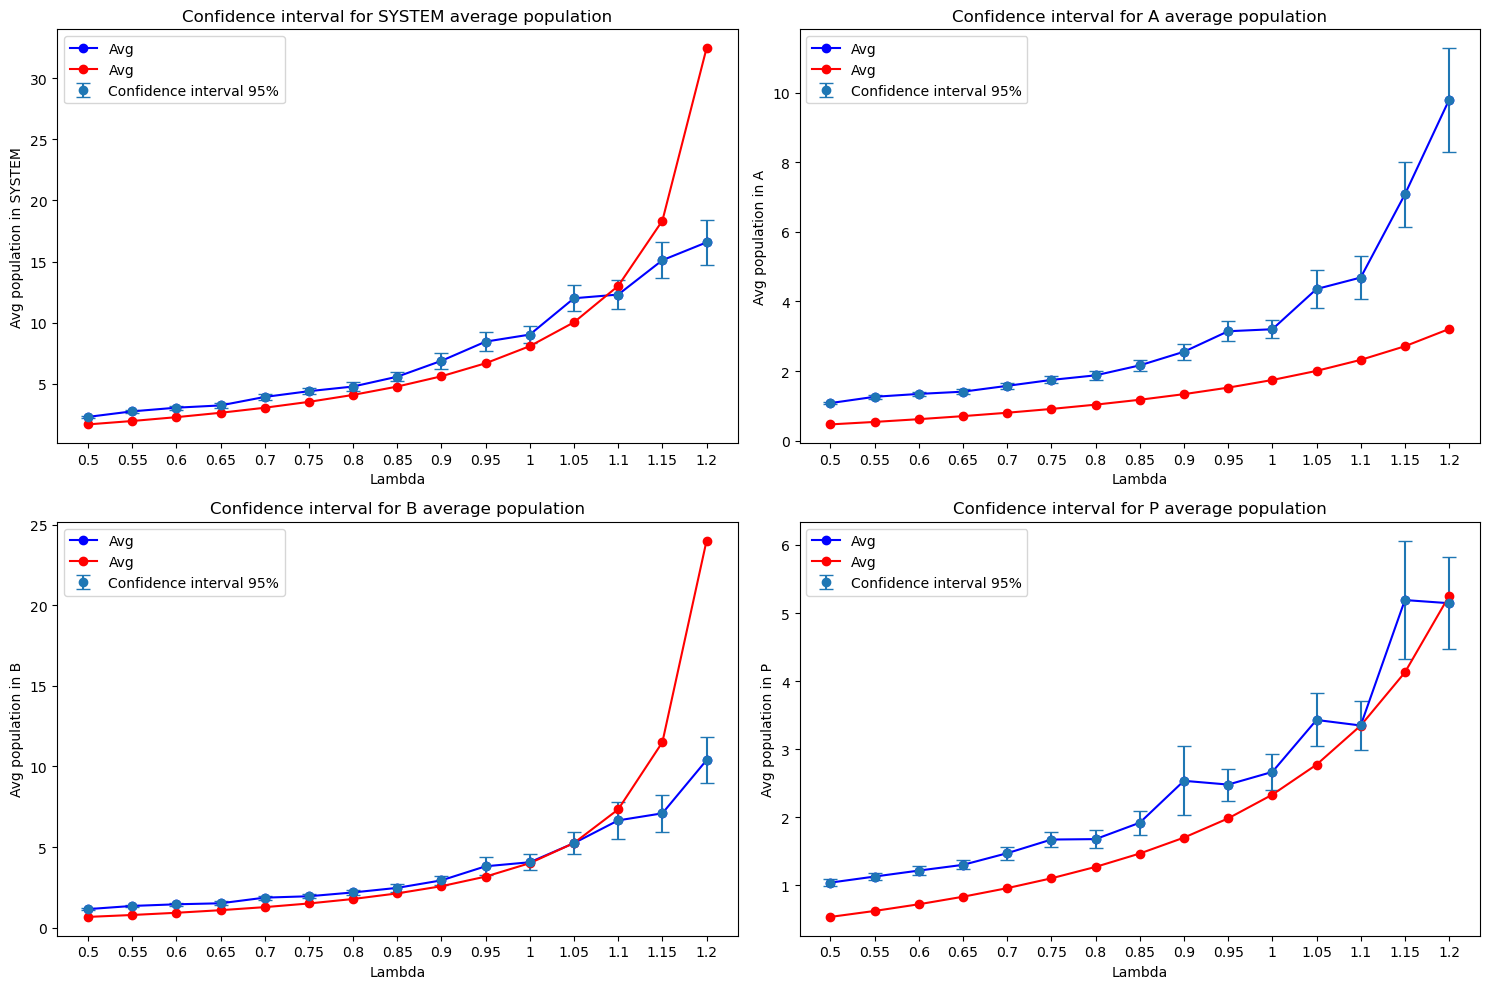

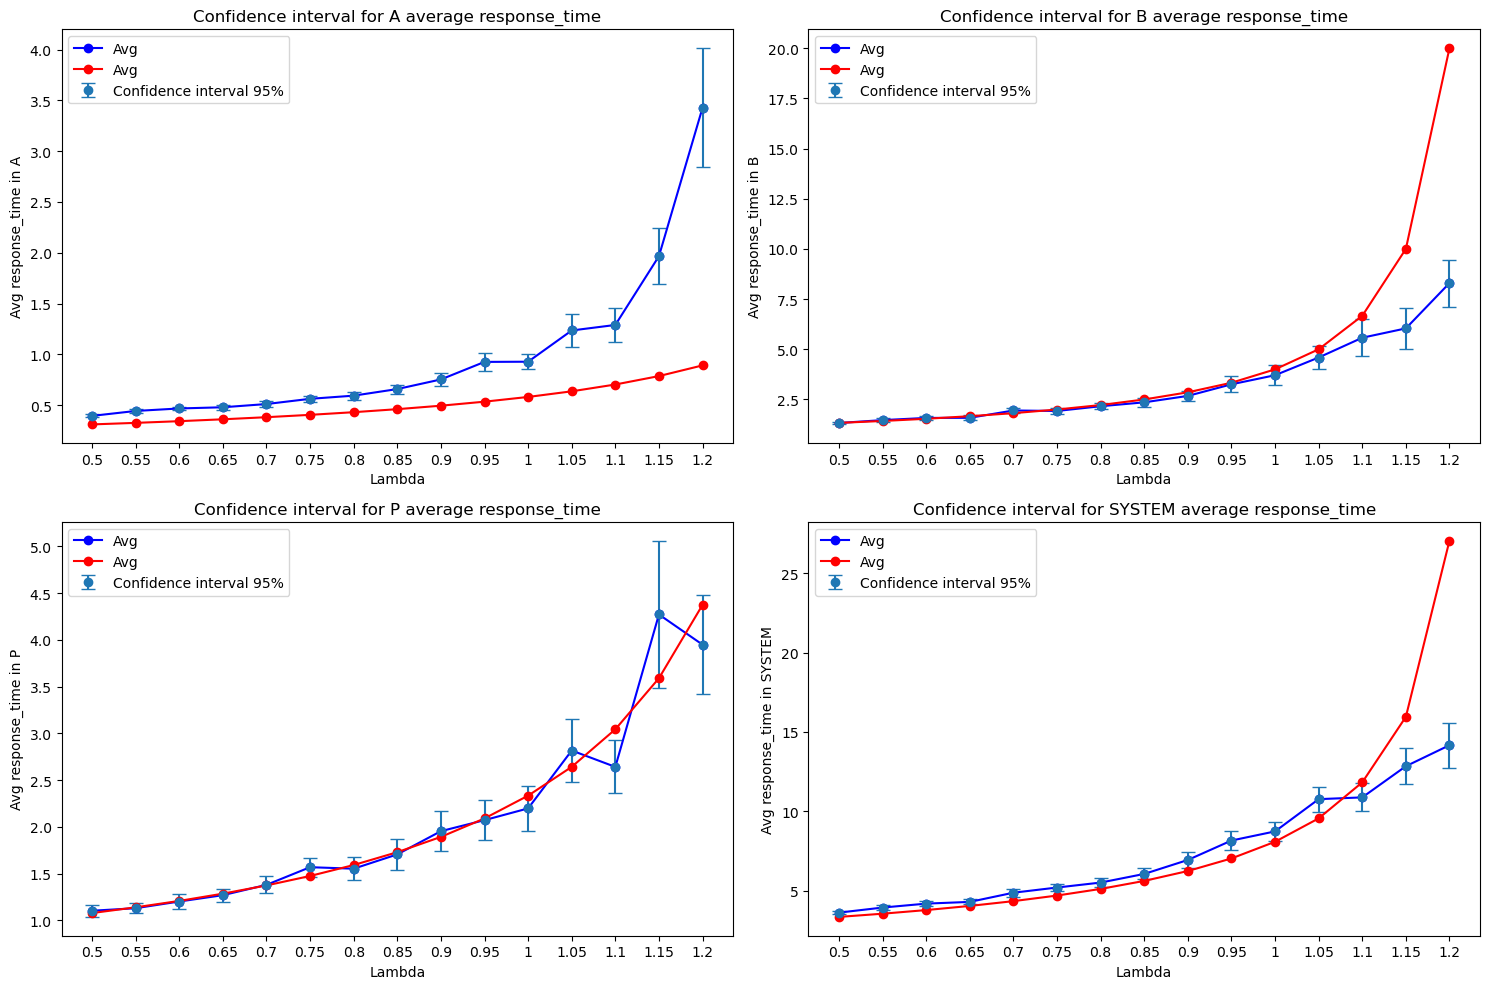

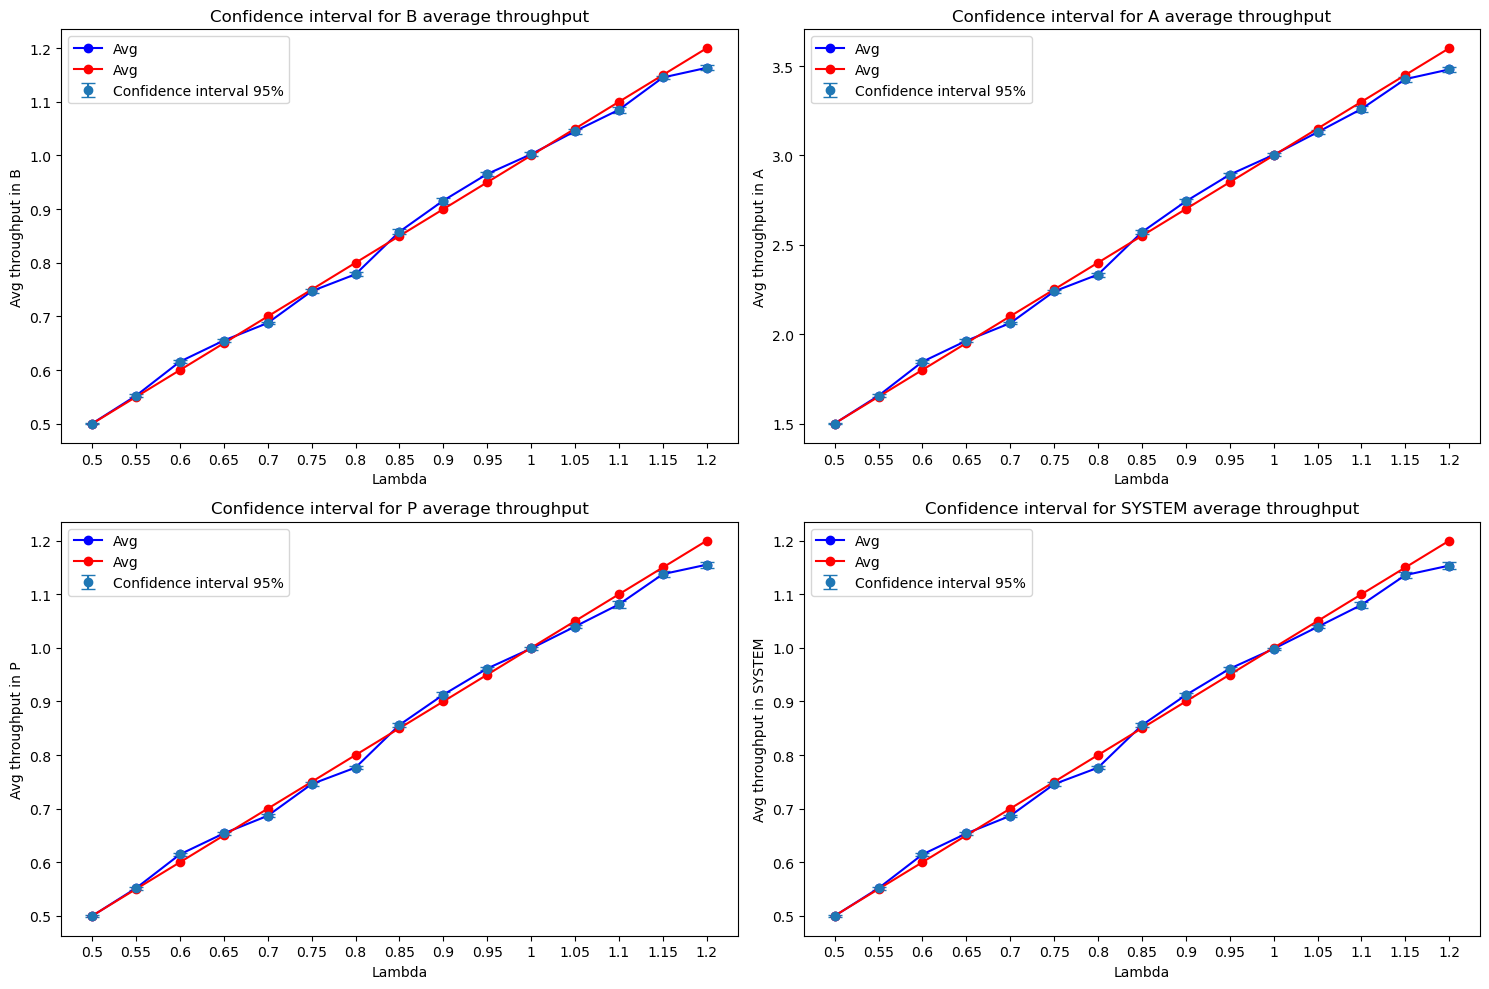

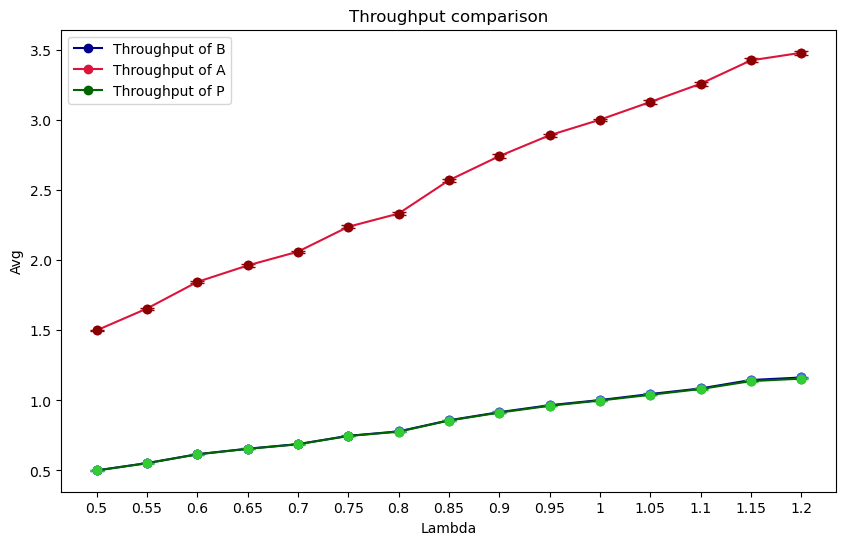

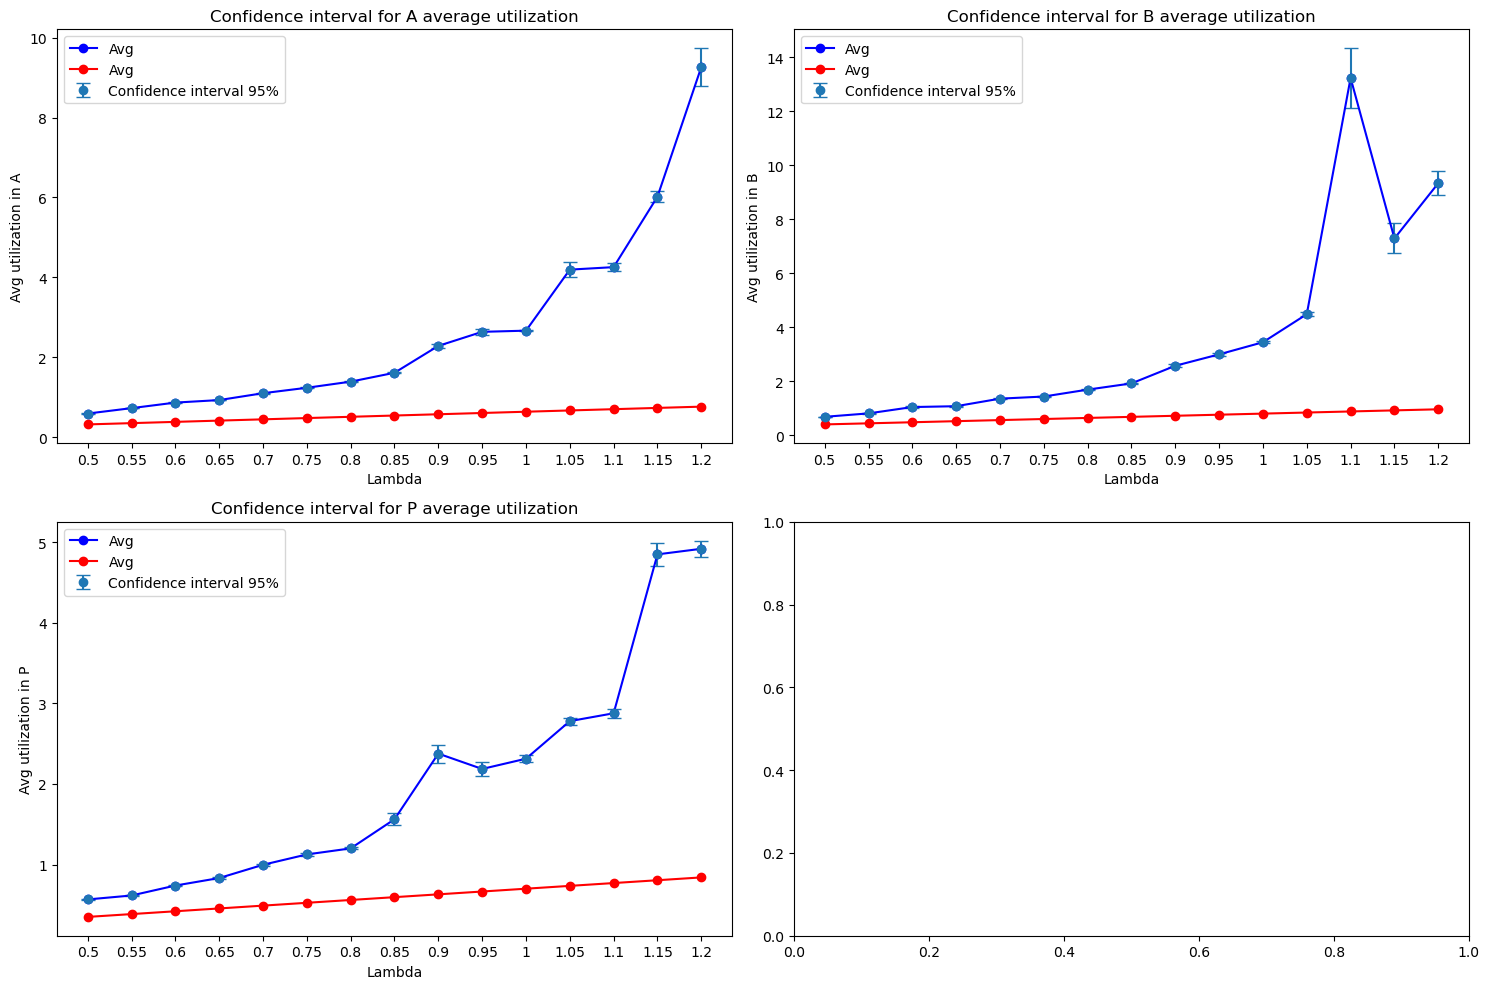

lambda,metric,node,simulation_value,analitycal_value,diff
0.5,population,SYSTEM,2.28466,1.67065,0.614019
0.55,population,SYSTEM,2.73831,1.9488,0.789508
0.6,population,SYSTEM,3.03815,2.26318,0.774963
0.65,population,SYSTEM,3.22442,2.6216,0.602815
0.7,population,SYSTEM,3.91702,3.03436,0.882664
0.75,population,SYSTEM,4.38894,3.51538,0.873562
0.8,population,SYSTEM,4.76876,4.084,0.684757
0.85,population,SYSTEM,5.57494,4.76805,0.806888
0.9,population,SYSTEM,6.8741,5.6093,1.26481
0.95,population,SYSTEM,8.44417,6.674,1.77017


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,population,A,1.07866,0.465517,0.613146
0.55,population,A,1.25919,0.537071,0.722118
0.6,population,A,1.34203,0.61597,0.726064
0.65,population,A,1.4063,0.703407,0.702892
0.7,population,A,1.57402,0.800847,0.773171
0.75,population,A,1.74409,0.910112,0.833981
0.8,population,A,1.87583,1.03349,0.842337
0.85,population,A,2.1622,1.17391,0.988287
0.9,population,A,2.55413,1.33516,1.21897
0.95,population,A,3.1437,1.52226,1.62144


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,population,B,1.15047,0.666667,0.483807
0.55,population,B,1.3465,0.785714,0.560785
0.6,population,B,1.44898,0.923077,0.525901
0.65,population,B,1.51119,1.08333,0.427858
0.7,population,B,1.86117,1.27273,0.588444
0.75,population,B,1.94782,1.5,0.447824
0.8,population,B,2.18354,1.77778,0.405762
0.85,population,B,2.46742,2.125,0.342421
0.9,population,B,2.93314,2.57143,0.361716
0.95,population,B,3.80672,3.16667,0.640051


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,population,P,1.042,0.538462,0.503539
0.55,population,P,1.13109,0.626016,0.505072
0.6,population,P,1.2188,0.724138,0.494657
0.65,population,P,1.30283,0.834862,0.46797
0.7,population,P,1.47394,0.960784,0.513152
0.75,population,P,1.67448,1.10526,0.569213
0.8,population,P,1.68071,1.27273,0.40798
0.85,population,P,1.92137,1.46914,0.452238
0.9,population,P,2.53695,1.7027,0.834246
0.95,population,P,2.48164,1.98507,0.496561


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,response_time,A,0.394355,0.310345,0.0840099
0.55,response_time,A,0.442703,0.325497,0.117206
0.6,response_time,A,0.467328,0.342205,0.125122
0.65,response_time,A,0.479035,0.360721,0.118314
0.7,response_time,A,0.510859,0.381356,0.129503
0.75,response_time,A,0.562207,0.404494,0.157713
0.8,response_time,A,0.593362,0.430622,0.16274
0.85,response_time,A,0.658334,0.460358,0.197976
0.9,response_time,A,0.752955,0.494505,0.258449
0.95,response_time,A,0.925619,0.534125,0.391495


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,response_time,B,1.3282,1.33333,0.00513488
0.55,response_time,B,1.47196,1.42857,0.0433887
0.6,response_time,B,1.58103,1.53846,0.0425639
0.65,response_time,B,1.58643,1.66667,0.0802377
0.7,response_time,B,1.95114,1.81818,0.132955
0.75,response_time,B,1.92742,2,0.0725813
0.8,response_time,B,2.16298,2.22222,0.0592397
0.85,response_time,B,2.35726,2.5,0.142738
0.9,response_time,B,2.67736,2.85714,0.179783
0.95,response_time,B,3.25462,3.33333,0.0787114


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,response_time,P,1.10172,1.07692,0.0248004
0.55,response_time,P,1.12881,1.13821,0.00940542
0.6,response_time,P,1.20047,1.2069,0.0064283
0.65,response_time,P,1.2682,1.2844,0.0162024
0.7,response_time,P,1.37876,1.37255,0.00620759
0.75,response_time,P,1.56768,1.47368,0.0939933
0.8,response_time,P,1.55169,1.59091,0.0392172
0.85,response_time,P,1.70484,1.7284,0.023556
0.9,response_time,P,1.9533,1.89189,0.0614087
0.95,response_time,P,2.07126,2.08955,0.0182929


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,response_time,SYSTEM,3.61212,3.34129,0.27083
0.55,response_time,SYSTEM,3.93022,3.54327,0.386947
0.6,response_time,SYSTEM,4.17821,3.77197,0.406232
0.65,response_time,SYSTEM,4.28709,4.03323,0.253859
0.7,response_time,SYSTEM,4.86578,4.3348,0.530983
0.75,response_time,SYSTEM,5.19246,4.68717,0.50529
0.8,response_time,SYSTEM,5.50462,5.105,0.399626
0.85,response_time,SYSTEM,6.04892,5.60947,0.439448
0.9,response_time,SYSTEM,6.92871,6.23255,0.696163
0.95,response_time,SYSTEM,8.15348,7.02526,1.12822


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,throughput,B,0.500248,0.5,0.000248293
0.55,throughput,B,0.552208,0.55,0.00220808
0.6,throughput,B,0.615738,0.6,0.0157377
0.65,throughput,B,0.655057,0.65,0.005057
0.7,throughput,B,0.687741,0.7,0.0122587
0.75,throughput,B,0.747038,0.75,0.00296221
0.8,throughput,B,0.778615,0.8,0.0213855
0.85,throughput,B,0.85782,0.85,0.0078205
0.9,throughput,B,0.915886,0.9,0.0158862
0.95,throughput,B,0.965472,0.95,0.0154725


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,throughput,A,1.49991,1.5,8.62464e-05
0.55,throughput,A,1.65547,1.65,0.00546658
0.6,throughput,A,1.84552,1.8,0.0455203
0.65,throughput,A,1.96293,1.95,0.012934
0.7,throughput,A,2.06145,2.1,0.0385473
0.75,throughput,A,2.23905,2.25,0.0109529
0.8,throughput,A,2.3335,2.4,0.0665039
0.85,throughput,A,2.57084,2.55,0.0208443
0.9,throughput,A,2.74311,2.7,0.0431091
0.95,throughput,A,2.89222,2.85,0.0422166


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,throughput,P,0.49976,0.5,0.000239825
0.55,throughput,P,0.551593,0.55,0.0015927
0.6,throughput,P,0.614717,0.6,0.0147172
0.65,throughput,P,0.653826,0.65,0.00382613
0.7,throughput,P,0.686706,0.7,0.0132939
0.75,throughput,P,0.745818,0.75,0.0041819
0.8,throughput,P,0.776625,0.8,0.023375
0.85,throughput,P,0.856165,0.85,0.00616516
0.9,throughput,P,0.912613,0.9,0.0126126
0.95,throughput,P,0.961455,0.95,0.0114546


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,throughput,SYSTEM,0.499698,0.5,0.000302122
0.55,throughput,SYSTEM,0.551476,0.55,0.00147602
0.6,throughput,SYSTEM,0.614468,0.6,0.0144684
0.65,throughput,SYSTEM,0.65365,0.65,0.00365044
0.7,throughput,SYSTEM,0.686504,0.7,0.0134964
0.75,throughput,SYSTEM,0.745672,0.75,0.00432815
0.8,throughput,SYSTEM,0.776409,0.8,0.0235907
0.85,throughput,SYSTEM,0.855687,0.85,0.00568728
0.9,throughput,SYSTEM,0.911912,0.9,0.0119122
0.95,throughput,SYSTEM,0.961063,0.95,0.0110628


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,utilization,A,0.589219,0.317647,0.271572
0.55,utilization,A,0.724943,0.349412,0.375532
0.6,utilization,A,0.8638,0.381176,0.482624
0.65,utilization,A,0.926836,0.412941,0.513895
0.7,utilization,A,1.09852,0.444706,0.653816
0.75,utilization,A,1.23495,0.476471,0.758483
0.8,utilization,A,1.38809,0.508235,0.879856
0.85,utilization,A,1.61029,0.54,1.07029
0.9,utilization,A,2.28338,0.571765,1.71162
0.95,utilization,A,2.63517,0.603529,2.03164


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,utilization,B,0.681588,0.4,0.281588
0.55,utilization,B,0.808003,0.44,0.368003
0.6,utilization,B,1.04306,0.48,0.563064
0.65,utilization,B,1.07449,0.52,0.554494
0.7,utilization,B,1.35427,0.56,0.794273
0.75,utilization,B,1.43297,0.6,0.832968
0.8,utilization,B,1.68869,0.64,1.04869
0.85,utilization,B,1.9191,0.68,1.2391
0.9,utilization,B,2.5726,0.72,1.8526
0.95,utilization,B,2.99559,0.76,2.23559


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,utilization,P,0.566773,0.35,0.216773
0.55,utilization,P,0.615635,0.385,0.230635
0.6,utilization,P,0.739008,0.42,0.319008
0.65,utilization,P,0.832138,0.455,0.377138
0.7,utilization,P,0.996574,0.49,0.506574
0.75,utilization,P,1.12498,0.525,0.599983
0.8,utilization,P,1.20001,0.56,0.64001
0.85,utilization,P,1.56135,0.595,0.966346
0.9,utilization,P,2.37579,0.63,1.74579
0.95,utilization,P,2.18547,0.665,1.52047


In [35]:
path = os.path.join("..", "..", "src", "caballo", "domestico", "wwsimulator", "statistics", "objective_2")
critical_value = scipy.stats.norm.ppf(1-.05/2)
obj = 'obj2'

metrics_nodes_avg_df_list = preprocessing(path, obj)
analytical_perf = analitycal_preprocessing(obj)

boxplot(metrics_nodes_avg_df_list)

ci_df = confidence_interval(metrics_nodes_avg_df_list, critical_value, obj)
plot_confidence_interval(ci_df, analytical_perf)

avg_metrics_list = average_stats(metrics_nodes_avg_df_list, analytical_perf)
for metric in avg_metrics_list:
    for node in metric:
        df = node.reset_index()
        df.drop(columns=['index'], inplace=True)
        display(tabulate(df, headers='keys', tablefmt='html', showindex=False))

## Objective 3

Measure the metrics with an increased workload from 4200 req/h to 5000 req/h

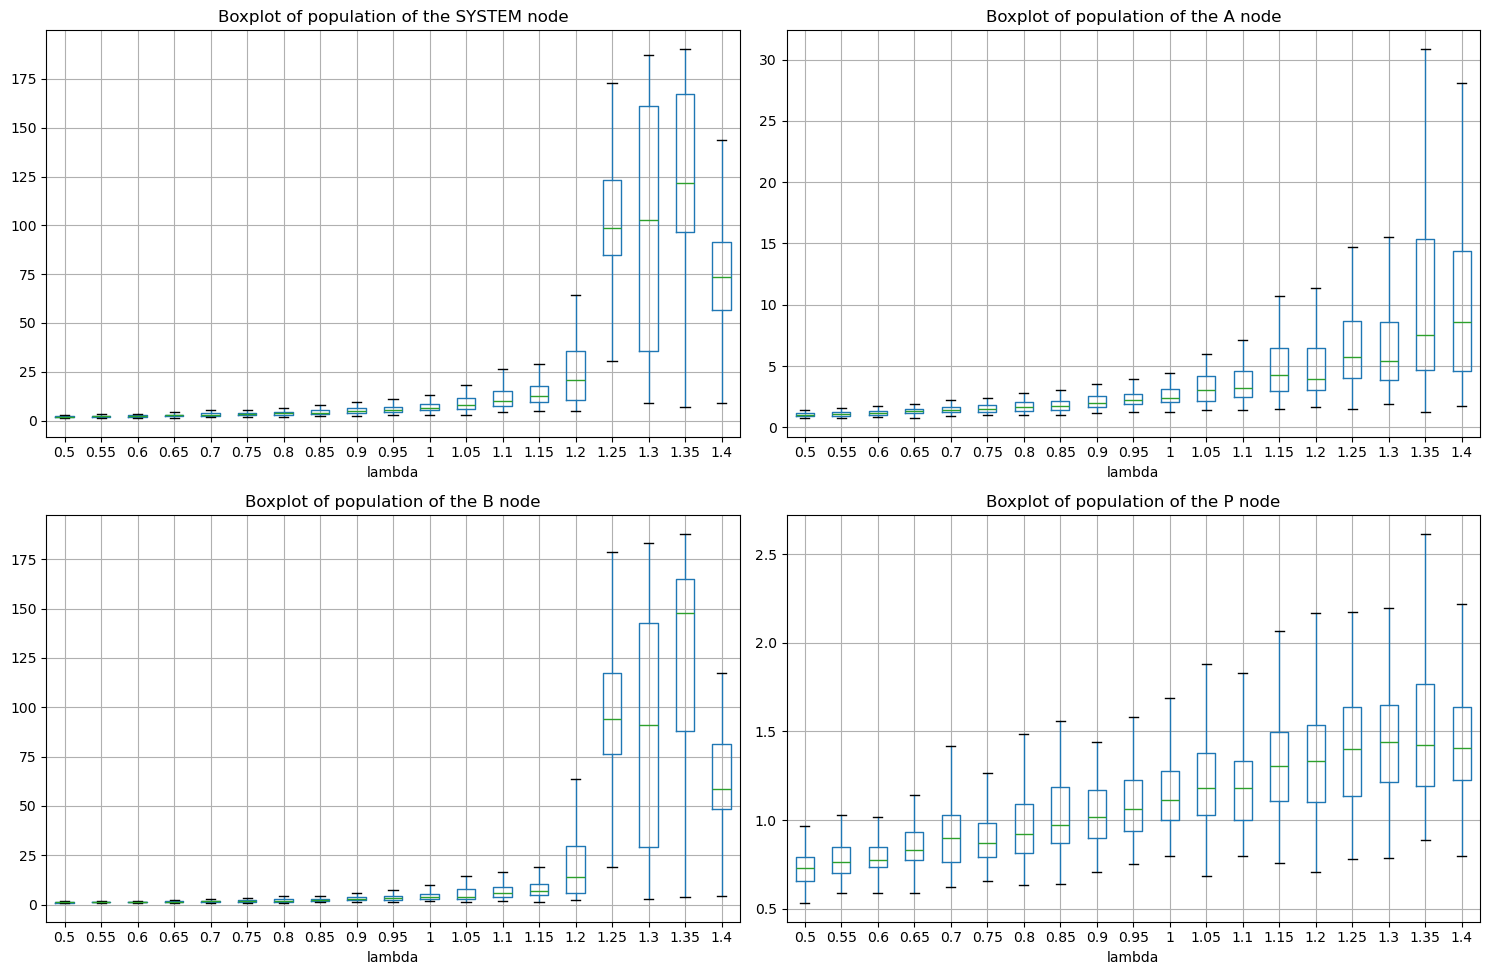

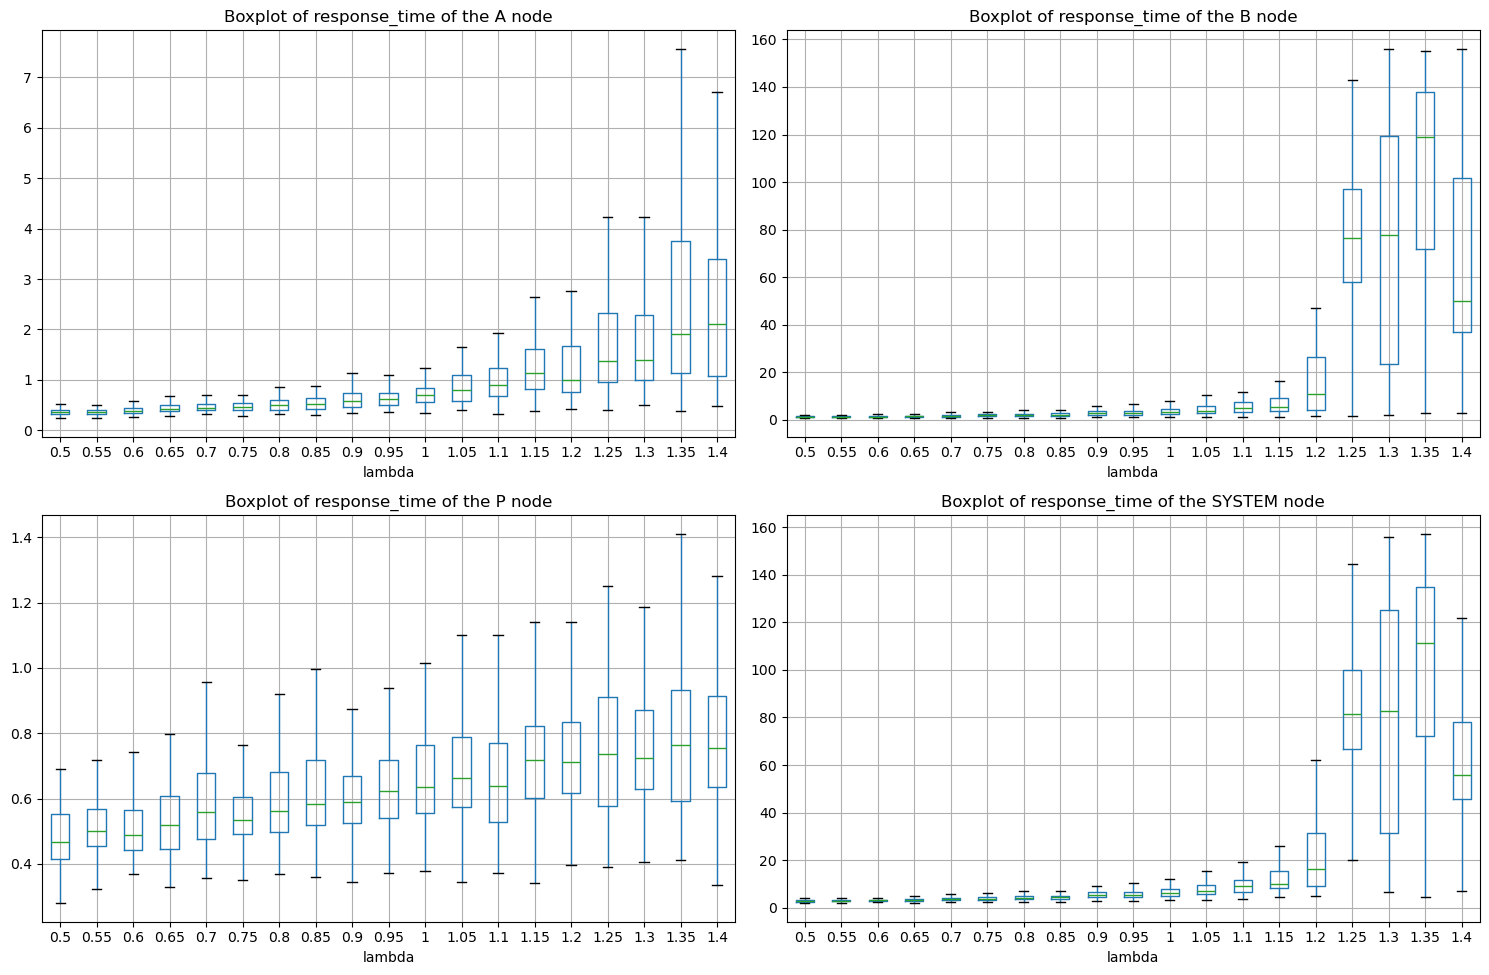

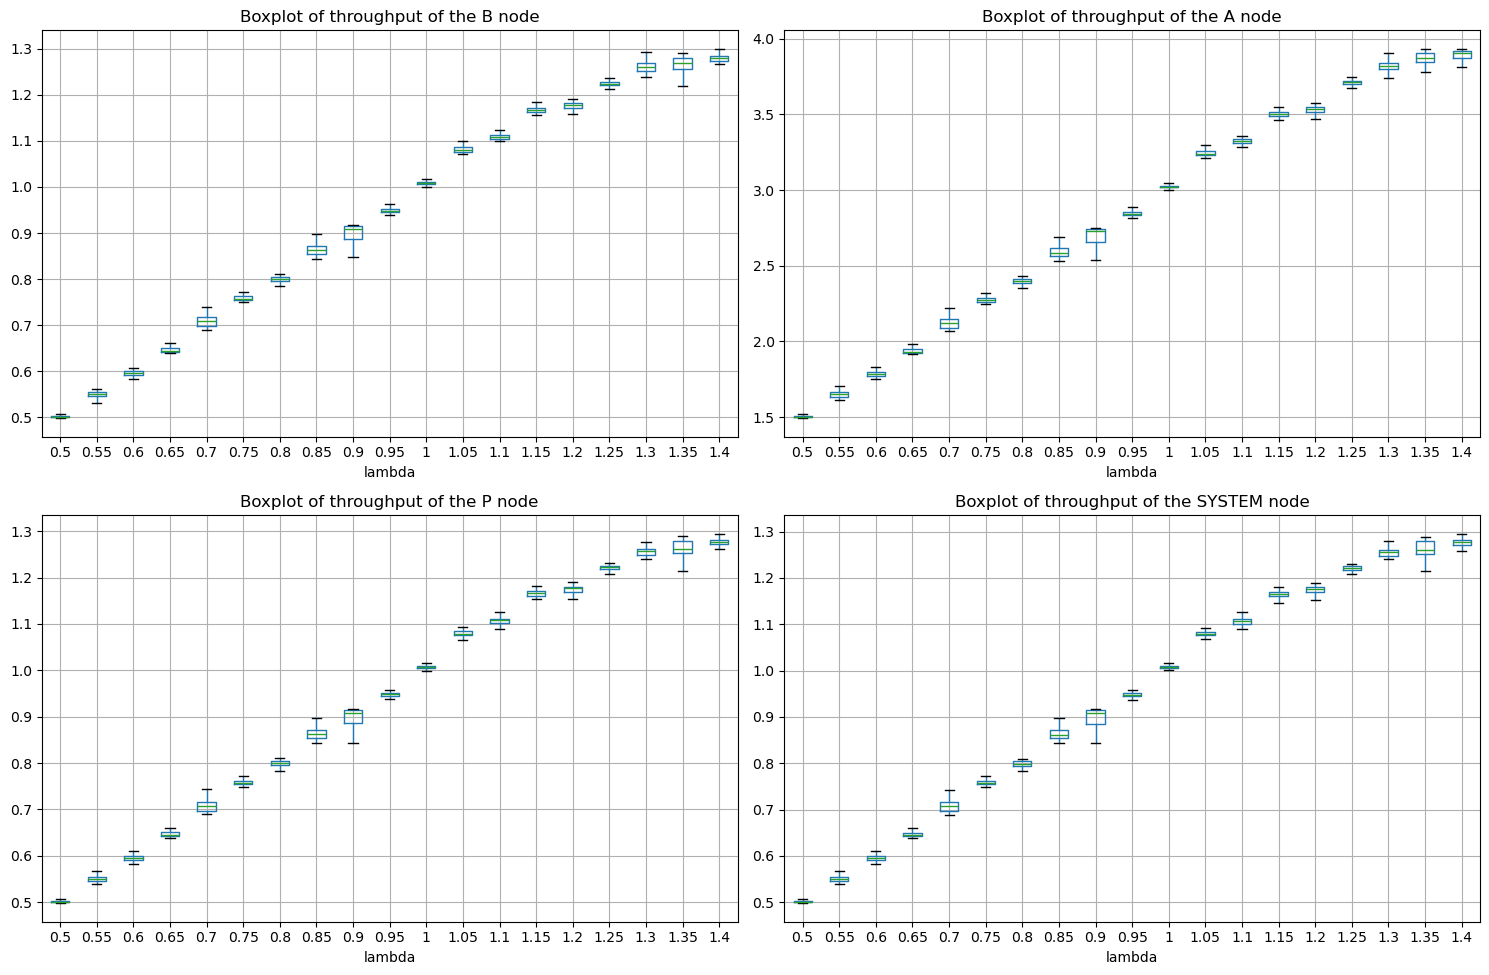

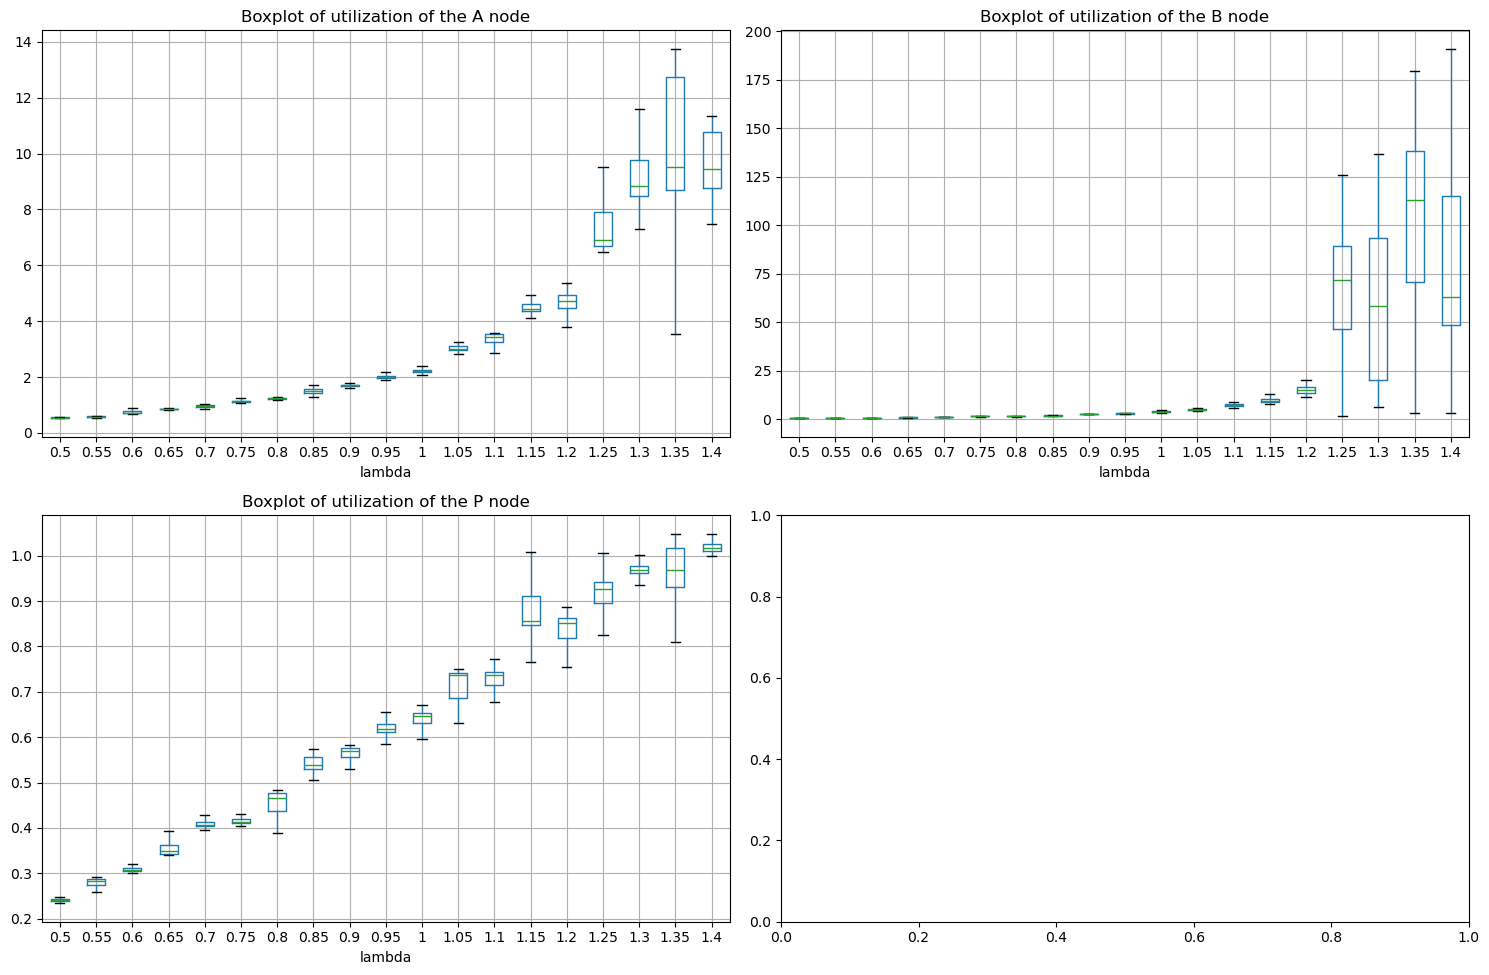

ValueError: x and y must have same first dimension, but have shapes (19,) and (15,)

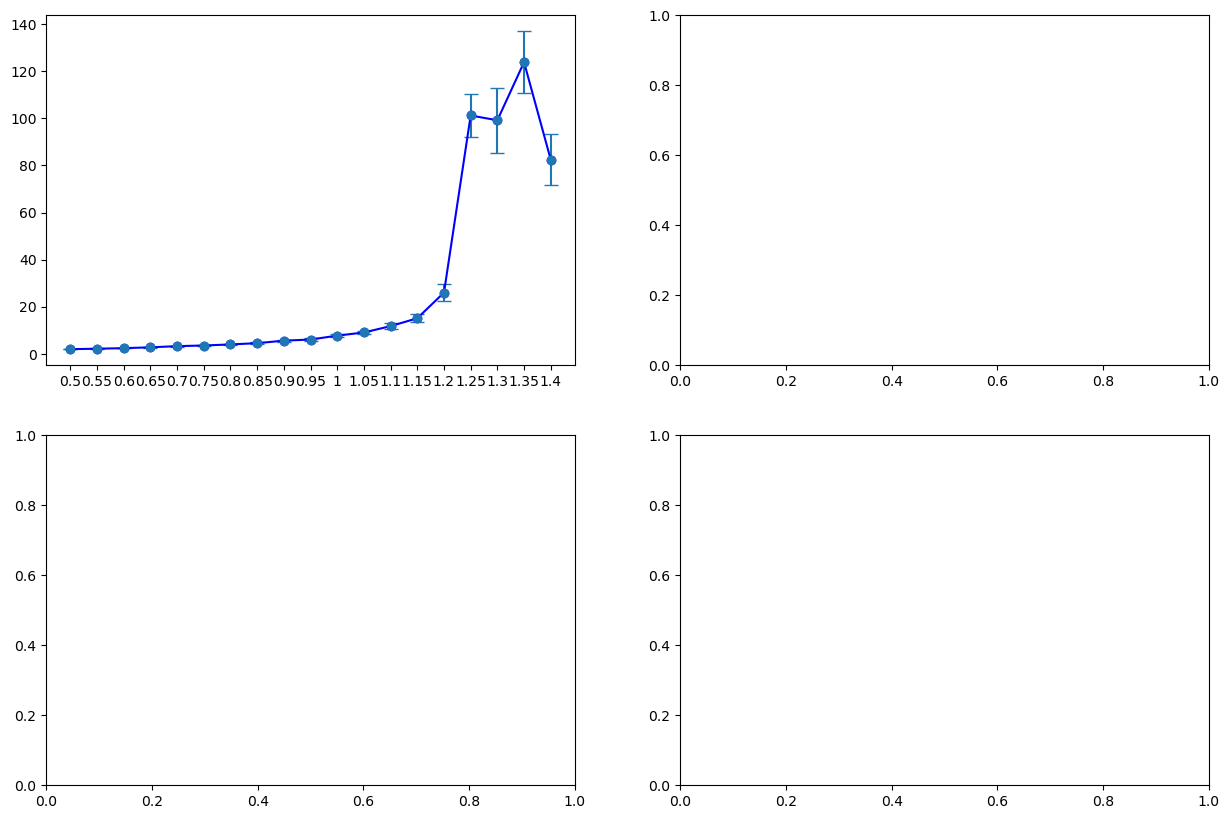

In [36]:
path = os.path.join("..", "..", "src", "caballo", "domestico", "wwsimulator", "statistics", "objective_3")
critical_value = scipy.stats.norm.ppf(1-.05/2)
obj = 'obj3'

metrics_nodes_avg_df_list = preprocessing(path, obj)
analytical_perf = analitycal_preprocessing(obj)

boxplot(metrics_nodes_avg_df_list)

ci_df = confidence_interval(metrics_nodes_avg_df_list, critical_value, obj)
plot_confidence_interval(ci_df, analytical_perf)

avg_metrics_list = average_stats(metrics_nodes_avg_df_list, analytical_perf)
for metric in avg_metrics_list:
    for node in metric:
        df = node.reset_index()
        df.drop(columns=['index'], inplace=True)
        display(tabulate(df, headers='keys', tablefmt='html', showindex=False))